# Yahoo Finanace Correlation Analysis
## Required libraries

In [1]:
# Yahoo Finanace API
import yfinance as yf

# Data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

from itertools import combinations

# For normalization
from sklearn.preprocessing import MinMaxScaler

## List of Tickers

## List of instrumetns

In [2]:
symbols = [
    'AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOGL', 'META', 'NVDA', 'BRK-B', 'XOM', 'JNJ',
    'V', 'PG', 'WMT', 'PFE', 'KO', 'CSCO', 'CVX', 'PEP', 'IBM', 'MRK', 'BYDDF',
    'IQQH.F', 'BTC-USD', 'ETH-USD', 'PYPL', 'BRK-A', 'CSPX.AS', 'GC=F', 'SI=F',
    'CL=F', 'UA', 'IT', 'VAPU.SW', 'SOL-USD', 'COIN'
]

# Functions
## Cleaning

In [3]:
def collect_nan_info(dataframe):
    """
    Collects columns and rows where NaN values are found in a dictionary form.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    dict: A dictionary where the keys are column names and the values are the indices (dates) of the missing values.
    """
    nan_info = {}

    for column in dataframe.columns:
        missing_indices = dataframe[column][dataframe[column].isnull()].index.tolist()
        if missing_indices:  # Only add if there are missing values
            nan_info[column] = missing_indices

    return nan_info

In [4]:
def clean_data(dataframe, max_consecutive_nans=3):
    """
    Cleans the input DataFrame by interpolating small gaps and removing columns with large gaps.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame.
    max_consecutive_nans (int): The maximum number of consecutive NaNs allowed for interpolation.

    Returns:
    pd.DataFrame: A new DataFrame with cleaned data.
    """
    cleaned_df = dataframe.copy()

    # Interpolate small gaps
    cleaned_df.interpolate(method='linear', inplace=True)

    # Remove columns with large gaps
    columns_to_remove = []
    for column in cleaned_df.columns:
        nan_groups = cleaned_df[column].isnull().astype(int).groupby(cleaned_df[column].notnull().astype(int).cumsum()).sum()
        if any(nan_groups > max_consecutive_nans):
            columns_to_remove.append(column)

    cleaned_df.drop(columns=columns_to_remove, inplace=True)

    # Remove rows with NaN values in the first row after interpolation
    if cleaned_df.iloc[0].isnull().any():
        cleaned_df.drop(index=cleaned_df.index[0], inplace=True)

    return cleaned_df


## Make weekly, monthly, quarterly and yearly lists
### Weekly list

In [5]:
def get_weekly_date_lists(start_date, end_date):
    """
    Creates a list of lists, where each sublist contains the dates of a week within the specified range.
    
    Parameters:
    start_date (str): The starting date in 'YYYY-MM-DD' format.
    end_date (str): The ending date in 'YYYY-MM-DD' format.
    
    Returns:
    list: A list of lists, where each sublist contains pandas Timestamp objects for each day of the week.
    """
    # Generate date range for the specified period
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Create an empty list to hold the weeks
    weekly_date_lists = []
    
    # Initialize the start of the first week
    week_start = date_range[0]
    
    # Iterate over the date range and create weekly lists
    for date in date_range[1:]:
        if date.weekday() == 0:  # First day of the week (Monday)
            # Append the dates from the start of the week to the day before this date
            weekly_date_lists.append(date_range[(date_range >= week_start) & (date_range < date)].tolist())
            week_start = date
    
    # Add the last week
    weekly_date_lists.append(date_range[(date_range >= week_start) & (date_range <= date_range[-1])].tolist())
    
    return weekly_date_lists

### Monthly list

In [6]:
def get_monthly_date_lists(start_date, end_date):
    """
    Creates a list of lists, where each sublist contains the dates of a month within the specified range.
    
    Parameters:
    start_date (str): The starting date in 'YYYY-MM-DD' format.
    end_date (str): The ending date in 'YYYY-MM-DD' format.
    
    Returns:
    list: A list of lists, where each sublist contains pandas Timestamp objects for each day of the month.
    """
    # Generate date range for the specified period
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Create an empty list to hold the months
    monthly_date_lists = []
    
    # Initialize the start of the first month
    month_start = date_range[0]
    
    # Iterate over the date range and create monthly lists
    for date in date_range[1:]:
        if date.day == 1:  # First day of the month
            # Append the dates from the start of the month to the day before this date
            monthly_date_lists.append(date_range[(date_range >= month_start) & (date_range < date)].tolist())
            month_start = date
    
    # Add the last month
    monthly_date_lists.append(date_range[(date_range >= month_start) & (date_range <= date_range[-1])].tolist())
    
    return monthly_date_lists

### Quarterly list

In [7]:
def get_quarterly_date_lists(start_date, end_date):
    """
    Creates a list of lists, where each sublist contains the dates of a quarter within the specified range.
    
    Parameters:
    start_date (str): The starting date in 'YYYY-MM-DD' format.
    end_date (str): The ending date in 'YYYY-MM-DD' format.
    
    Returns:
    list: A list of lists, where each sublist contains pandas Timestamp objects for each day of the quarter.
    """
    # Generate date range for the specified period
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Create an empty list to hold the quarters
    quarterly_date_lists = []
    
    # Initialize the start of the first quarter
    quarter_start = date_range[0]
    
    # Iterate over the date range and create quarterly lists
    for date in date_range[1:]:
        if (date.month - 1) % 3 == 0 and date.day == 1:  # First day of a quarter (January, April, July, October)
            # Append the dates from the start of the quarter to the day before this date
            quarterly_date_lists.append(date_range[(date_range >= quarter_start) & (date_range < date)].tolist())
            quarter_start = date
    
    # Add the last quarter
    quarterly_date_lists.append(date_range[(date_range >= quarter_start) & (date_range <= date_range[-1])].tolist())
    
    return quarterly_date_lists

### Yearly list

In [8]:
def get_yearly_date_lists(start_date, end_date):
    """
    Creates a list of lists, where each sublist contains the dates of a year within the specified range.
    
    Parameters:
    start_date (str): The starting date in 'YYYY-MM-DD' format.
    end_date (str): The ending date in 'YYYY-MM-DD' format.
    
    Returns:
    list: A list of lists, where each sublist contains pandas Timestamp objects for each day of the year.
    """
    # Generate date range for the specified period
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Create an empty list to hold the years
    yearly_date_lists = []
    
    # Initialize the start of the first year
    year_start = date_range[0]
    
    # Iterate over the date range and create yearly lists
    for date in date_range[1:]:
        if date.month == 1 and date.day == 1:  # First day of the year (January 1st)
            # Append the dates from the start of the year to the day before this date
            yearly_date_lists.append(date_range[(date_range >= year_start) & (date_range < date)].tolist())
            year_start = date
    
    # Add the last year
    yearly_date_lists.append(date_range[(date_range >= year_start) & (date_range <= date_range[-1])].tolist())
    
    return yearly_date_lists

## Find week, month, quarter or year
### Week finder

In [9]:
def find_week_containing_date(weekly_dates, target_date):
    """
    Finds and returns the week containing the target date from the weekly date lists.
    
    Parameters:
    weekly_dates (list): A list of lists, where each sublist contains pandas Timestamp objects for each day of the week.
    target_date (str): The target date in 'YYYY-MM-DD' format.
    
    Returns:
    list: The week containing the target date.
    """
    target_date = pd.Timestamp(target_date)
    
    for week in weekly_dates:
        if target_date in week:
            return week
    
    return print("Inappropriate date")

### Month finder

In [10]:
def find_month_containing_date(monthly_dates, target_date):
    """
    Finds and returns the month containing the target date from the monthly date lists.
    
    Parameters:
    monthly_dates (list): A list of lists, where each sublist contains pandas Timestamp objects for each day of the month.
    target_date (str): The target date in 'YYYY-MM-DD' format.
    
    Returns:
    list: The month containing the target date.
    """
    target_date = pd.Timestamp(target_date)
    
    for month in monthly_dates:
        if target_date in month:
            return month
    
    return print("Inappropriate date")

### Quarter finder

In [11]:
def find_quarter_containing_date(quarterly_dates, target_date):
    """
    Finds and returns the quarter containing the target date from the quarterly date lists.
    
    Parameters:
    quarterly_dates (list): A list of lists, where each sublist contains pandas Timestamp objects for each day of the quarter.
    target_date (str): The target date in 'YYYY-MM-DD' format.
    
    Returns:
    list: The quarter containing the target date.
    """
    target_date = pd.Timestamp(target_date)
    
    for quarter in quarterly_dates:
        if target_date in quarter:
            return quarter
    
    return print("Inappropriate date")

### Year finder

In [12]:
def find_year_containing_date(yearly_dates, target_date):
    """
    Finds and returns the year containing the target date from the yearly date lists.
    
    Parameters:
    yearly_dates (list): A list of lists, where each sublist contains pandas Timestamp objects for each day of the year.
    target_date (str): The target date in 'YYYY-MM-DD' format.
    
    Returns:
    list: The year containing the target date.
    """
    target_date = pd.Timestamp(target_date)
    
    for year in yearly_dates:
        if target_date in year:
            return year
    
    return print("Inappropriate date")

## Correlation calculating
### Weekly

### Weekly, monthly, quarterly, yearly correlation

In [13]:
def calculate_correlations(all_data, start_date, end_date, frequency='weekly'):
    """
    Calculate correlations for all columns in the dataframe within the given date range and specified frequency.
    
    Parameters:
    all_data (pd.DataFrame): The input dataframe with date-indexed data.
    start_date (str): The starting date in 'YYYY-MM-DD' format.
    end_date (str): The ending date in 'YYYY-MM-DD' format.
    frequency (str): The frequency of the correlations ('weekly', 'monthly', 'quarterly', 'yearly').
    
    Returns:
    dict: A dictionary where keys are period start dates and values are correlation matrices.
    """

    # Create lists of date ranges based on the specified frequency
    if frequency == 'weekly':
        date_lists = get_weekly_date_lists(start_date, end_date)
    elif frequency == 'monthly':
        date_lists = get_monthly_date_lists(start_date, end_date)
    elif frequency == 'quarterly':
        date_lists = get_quarterly_date_lists(start_date, end_date)
    elif frequency == 'yearly':
        date_lists = get_yearly_date_lists(start_date, end_date)
    else:
        raise ValueError("Frequency must be one of 'weekly', 'monthly', 'quarterly', 'yearly'.")

    # Filter out dates that do not exist in the dataframe's index
    existing_dates = set(all_data.index)
    date_lists = [[date for date in period if date in existing_dates] for period in date_lists]
    
    # Initialize the scaler for normalization
    scaler = MinMaxScaler()
    correlations = {}
    
    # Iterate over each list of dates
    for period_dates in date_lists:
        # Skip periods with less than two dates
        if len(period_dates) < 2:
            continue
        
        # Extract data for the current period and drop missing values
        period_data = all_data.loc[all_data.index.isin(period_dates)].dropna()
        
        # If there is data for the period
        if not period_data.empty:
            # Normalize the data
            normalized_data = pd.DataFrame(scaler.fit_transform(period_data), columns=period_data.columns, index=period_data.index)
            # Calculate the correlation matrix
            correlation_matrix = normalized_data.corr()
            
            # Use the start date of the period as the key in the dictionary
            period_start_date = period_dates[0]
            correlations[period_start_date] = correlation_matrix
    
    return correlations

### Analysis of correlation distribution

In [14]:
def check_normal_distribution_and_plot(weekly_correlations):
    """
    Check the normal distribution of correlation values for each stock pair and plot histograms
    for those that are normally distributed.
    
    Parameters:
    weekly_correlations (dict): A dictionary of weekly correlation matrices.
    """
    # Initialize a dictionary to store the correlation values for each stock pair
    pairwise_correlations = {pair: [] for pair in [(i, j) for i in cleaned_data.columns for j in cleaned_data.columns if i != j]}
    
    # Collect correlation values for each pair
    for corr_matrix in weekly_correlations.values():
        for i in corr_matrix.columns:
            for j in corr_matrix.columns:
                if i != j:
                    pairwise_correlations[(i, j)].append(corr_matrix.loc[i, j])
    
    # Track if any normal distributions are found
    normal_distributions_found = False
    
    # Plot histogram and perform Shapiro-Wilk test for each pair
    for pair, correlations in pairwise_correlations.items():
        correlations = np.array(correlations)
        
        # Shapiro-Wilk test
        shapiro_test = stats.shapiro(correlations)
        if shapiro_test.pvalue >= 0.05:
            normal_distributions_found = True
            # Plot histogram only if the distribution is normal
            plt.figure(figsize=(10, 6))
            sns.histplot(correlations, bins=30, kde=True)
            plt.title(f'Histogram of Correlation Coefficients for {pair}')
            plt.xlabel('Correlation Coefficient')
            plt.ylabel('Frequency')
            plt.show()
            
            print(f'Shapiro-Wilk test for {pair}: statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')
            print(f"The correlation coefficients for {pair} are normally distributed (fail to reject H0).")
    
    if not normal_distributions_found:
        print("None of the stock pairs have normally distributed correlation coefficients.")

## Predictions

In [15]:
# Finding the slope of a line fitted to shares and normalized
def calculate_normalized_slope_predictions(cleaned_data, start_date):
    """
    Calculate the slope of the linear regression line for each stock in the cleaned_data
    from the start_date to the latest available date using np.polyfit on normalized data.

    Parameters:
    cleaned_data (pd.DataFrame): The cleaned data DataFrame with stock prices.
    start_date (str): The starting date in 'YYYY-MM-DD' format.

    Returns:
    dict: A dictionary where the keys are stock tickers and the values are the slopes of the regression lines.
    """
    # Filter the data from start_date to the latest available date
    filtered_data = cleaned_data.loc[start_date:]
    
    # Initialize a scaler
    scaler = MinMaxScaler()
    
    # Normalize the data
    normalized_data = pd.DataFrame(scaler.fit_transform(filtered_data), columns=filtered_data.columns, index=filtered_data.index)
    
    # Initialize a dictionary to store the slopes
    slopes = {}
    
    for stock in normalized_data.columns:
        # Prepare the data for linear regression using np.polyfit
        x = np.arange(len(normalized_data))
        y = normalized_data[stock].values
        
        # Fit the linear regression model and get the slope
        slope, intercept = np.polyfit(x, y, 1)
        slopes[stock] = slope

    normalized_slopes_df = pd.DataFrame.from_dict(slopes, orient='index')
    normalized_slopes_df.columns = ['normalized_slopes']
    return normalized_slopes_df

## Categorisation of financial assets

In [16]:
def categorize_stocks(symbols):
    # Creates an empty dictionary to store categorized stocks
    categorized_stocks = {}
    
    # Iterates over the list of stock symbols
    for symbol in symbols:
        try:
            # Retrieves stock information using the Yahoo Finance library
            stock = yf.Ticker(symbol)
            info = stock.info
            
            # Extracts the stock's sector
            sector = info.get('sector', 'Unknown')
            
            # If the sector is not available, retrieves the stock's quote type and adds it to the 'Unknown' sector
            if sector == 'Unknown':
                quote_type = info.get('quoteType', 'Unknown')
                sector = f"Unknown ({quote_type})"
            
            # If the sector is not already in the dictionary, adds it with an empty list
            if sector not in categorized_stocks:
                categorized_stocks[sector] = []
                
            # Adds the stock symbol to the appropriate sector list
            categorized_stocks[sector].append(symbol)
        
        # If any error occurs while retrieving the data, prints an error message
        except Exception as e:
            print(f"Could not retrieve data for {symbol}: {e}")
    
    # Returns the dictionary containing categorized stocks
    return categorized_stocks

## Finding the best combinations

In [17]:
def find_best_stock_combinations(corr_matrix, slopes_df, categorized_stocks, num_stocks=4, top_n=None):
    """
    Find the best combinations of stocks with the lowest average absolute correlation and highest slopes,
    ensuring no two stocks in the combination are from the same sector.

    Parameters:
    corr_matrix (pd.DataFrame): The median correlation matrix.
    slopes_df (pd.DataFrame): The normalized slopes dataframe.
    categorized_stocks (dict): Dictionary of stocks categorized by sector.
    num_stocks (int): Number of stocks in each combination.
    top_n (int or None): Number of top combinations to return. If None, return all combinations.

    Returns:
    list: List of tuples containing the best stock combinations and their average slopes and correlations.
    """   
    # Filter out stocks with non-positive slopes
    positive_slopes_df = slopes_df[slopes_df['normalized_slopes'] > 0]
    
    # Get all possible combinations of the given number of stocks from the positive slopes dataframe
    stock_combinations = list(combinations(positive_slopes_df.index, num_stocks))
    
    # Temporary storage for stock combinations by categories
    stock_combinations_cat = []
    
    # Iterate over the list of stock combinations
    for stock_combination in stock_combinations:
        # Temporary storage for categories of each combination
        tmp_cat = []
        for stock in stock_combination:
            # Find the category for each stock from the dictionary
            for category, stocks in categorized_stocks.items():
                if stock in stocks:
                    tmp_cat.append(category)
                    break
        stock_combinations_cat.append(tmp_cat)
    
    # List to store valid stock combinations
    valid_stock_combinations = []
    
    # Iterate over both lists in parallel
    for stocks, categories in zip(stock_combinations, stock_combinations_cat):
        # Check if all categories are different
        if len(set(categories)) == len(categories):
            # If yes, add the valid combination to the list
            valid_stock_combinations.append(stocks)

    best_combinations = []
    for combo in valid_stock_combinations:
        # Calculate the average absolute correlation for the combination
        median_corr = np.median([abs(corr_matrix.loc[i, j]) for i, j in combinations(combo, 2)])
        
        # Calculate the average slope for the combination
        median_slope = positive_slopes_df.loc[list(combo), 'normalized_slopes'].median()
        
        best_combinations.append((combo, median_corr, median_slope))
    
    # Sort the combinations first by average absolute correlation (ascending) and then by average slope (descending)
    best_combinations = sorted(best_combinations, key=lambda x: (x[1], -x[2]))

    # Assume that the best_combinations list is not empty
    if best_combinations:
        # Iterate through the elements of the best_combinations list
        for i in range(len(best_combinations)):
            # The first element of the i-th element of the best_combinations list is a tuple
            combination_tuple = best_combinations[i][0]
            
            # The tuple is converted to a list
            combination_list = list(combination_tuple)
            
            # Update the best_combinations list with the modified list
            best_combinations[i] = [combination_list, *best_combinations[i][1:]]
    
    if top_n is not None:
        return best_combinations[:top_n]
    else:
        return best_combinations

    for combo in valid_stock_combinations:
        # Calculate the average absolute correlation for the combination
        median_corr = np.median([abs(corr_matrix.loc[i, j]) for i, j in combinations(combo, 2)])
        
        # Calculate the average slope for the combination
        median_slope = positive_slopes_df.loc[list(combo), 'normalized_slopes'].median()
        
        best_combinations.append((combo, median_corr, median_slope))
    
    # Sort the combinations first by average absolute correlation (ascending) and then by average slope (descending)
    best_combinations = sorted(best_combinations, key=lambda x: (x[1], -x[2]))

    # Convert the entire best_combinations from tuples to lists
    best_combinations = [list(item) for item in best_combinations]

     # Assume that the best_combinations list is not empty
    if best_combinations:
        # Iterate through the elements of the best_combinations list
        for i in range(len(best_combinations)):
            # The first element of the i-th element of the best_combinations list is a tuple
            combination_tuple = best_combinations[i][0]
            
            # The tuple is converted to a list
            combination_list = list(combination_tuple)
            
            # Update the best_combinations list with the modified list
            best_combinations[i] = (combination_list, *best_combinations[i][1:])
            
    if top_n is not None:
        return best_combinations[:top_n]
    else:
        return best_combinations

## Vizualizations
### Median correlation heat

In [18]:
def plot_median_correlation_heatmap(cleaned_data, weekly_correlations):
    """
    Calculates the median correlations for each stock pair from weekly correlation matrices
    and plots a heatmap.

    Parameters:
    cleaned_data (pd.DataFrame): The cleaned data DataFrame.
    weekly_correlations (dict): Dictionary of weekly correlation matrices.

    Returns:
    pd.DataFrame: The median correlation matrix.
    """
    # Initialize a dictionary to store the correlation values for each stock pair
    pairwise_correlations = {pair: [] for pair in [(i, j) for i in cleaned_data.columns for j in cleaned_data.columns if i != j]}
    
    # Collect correlation values for each pair
    for corr_matrix in weekly_correlations.values():
        for i in corr_matrix.columns:
            for j in corr_matrix.columns:
                if i != j:
                    pairwise_correlations[(i, j)].append(corr_matrix.loc[i, j])
    
    # Create an empty DataFrame for the median correlations
    median_corr_matrix = pd.DataFrame(index=cleaned_data.columns, columns=cleaned_data.columns)
    
    # Compute median correlation for each stock pair and fill the matrix
    for i in cleaned_data.columns:
        for j in cleaned_data.columns:
            if i != j:
                correlations = pairwise_correlations[(i, j)]
                median_correlation = np.median(correlations)
                median_corr_matrix.loc[i, j] = median_correlation
    
    # Fill the diagonal with 1s
    np.fill_diagonal(median_corr_matrix.values, 1)
    
    # Convert the DataFrame to numeric type
    median_corr_matrix = median_corr_matrix.astype(float).round(2)
    
    # Plot the heatmap
    plt.figure(figsize=(18, 10))
    sns.heatmap(median_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Median Correlation Heatmap')
    plt.show()
    
    return median_corr_matrix

### Visualisation normalized data

In [19]:
def plot_selected_stocks_with_normalized_regression(cleaned_data, start_date, selected_stocks, slopes):
    """
    Plot the stock prices and the regression lines for the selected stocks using normalized data.

    Parameters:
    cleaned_data (pd.DataFrame): The cleaned data DataFrame with stock prices.
    start_date (str): The starting date in 'YYYY-MM-DD' format.
    selected_stocks (list): List of stock tickers to plot.
    slopes (dict): Dictionary of stock tickers and their corresponding slopes.
    """
    # Filter the data from start_date to the latest available date
    filtered_data = cleaned_data.loc[start_date:]
    
    # Initialize a scaler
    scaler = MinMaxScaler()
    
    # Normalize the data
    normalized_data = pd.DataFrame(scaler.fit_transform(filtered_data), columns=filtered_data.columns, index=filtered_data.index)
    
    for stock in selected_stocks:
        # Prepare the data for linear regression using the slopes dictionary
        x = np.arange(len(normalized_data))
        y = normalized_data[stock].values
        slope = slopes[stock]
        intercept = np.mean(y) - slope * np.mean(x)
        
        # Plot the stock price and the regression line
        plt.figure(figsize=(10, 6))
        plt.plot(normalized_data.index, normalized_data[stock], label=f'{stock} Price (Normalized)')
        plt.plot(normalized_data.index, slope * x + intercept, label='Regression Line', linestyle='--')
        plt.title(f'{stock} Price Prediction (Normalized)')
        plt.xlabel('Date')
        plt.ylabel('Normalized Price')
        plt.legend()
        plt.show()

## Calculating the value of an investment

In [20]:
def calculate_investment_value(cleaned_data, best_combinations, purchase_date, investment_amount):
    """
    Calculate the value of the investment from the specified starting date to the latest available date.

    Parameters:
    cleaned_data (pd.DataFrame): the data contains the stock market quotes.
    best_combinations (list of tuples): The best combinations, where each combination (ticker, ...).
    purchase_date (str): Date of purchase.
    investment_amount (float): The amount of the initial investment.

    Returns:
    dict: Dictionary of ticker combinations and their individual and total current values.
    """
    current_date = cleaned_data.index[-1]
    print(f"Purchase date: {purchase_date}, Last date: {current_date.date()}")
    
    results = {}
    for comb in best_combinations:
        tickers = comb[0]
        # Get initial exchange rates
        initial_prices = cleaned_data.loc[purchase_date, tickers]

        # Get current exchange rates
        current_prices = cleaned_data.loc[current_date, tickers]

        # Calculate how many shares we could have bought for the investment amount
        shares_bought = investment_amount / initial_prices

        # Calculate the current value of the shares
        current_value = shares_bought * current_prices

        # Create a dictionary to store individual values
        individual_values = dict(zip(tickers, current_value))

        # Total value
        total_current_value = current_value.sum()

        results[tuple(tickers)] = {
            "individual_values": individual_values,
            "total_value": total_current_value
        }
        print(f"Assets: {tickers}, Individual values: { {ticker: f'{value:.2f}' for ticker, value in individual_values.items()} }, Total value: {total_current_value:.2f}")
    
    return results

## Portfolio value vizulaization

In [21]:
def visualize_portfolio(cleaned_data, purchase_date, best_combinations, investment_amount):
    """
    Visualizes the stock values and investment portfolio over time for all given stock combinations.

    Parameters:
    cleaned_data (pd.DataFrame): DataFrame containing the stock price data.
    purchase_date (str): The date of the initial stock purchase.
    best_combinations (list): List containing the best stock combinations.
    investment_amount (float): The amount of money invested.

    Returns:
    None: Displays the plot.
    """
    
    # Loop through each combination in best_combinations
    for comb in best_combinations:
        plt.figure(figsize=(14, 8))
        tickers = comb[0]
        
        # Initial prices of the selected stocks at the purchase date
        initial_prices = cleaned_data.loc[purchase_date, tickers]
        
        # Calculate the number of shares bought for each stock
        shares_bought = investment_amount / initial_prices

        # Calculate the cumulative value over time
        df_value = cleaned_data[tickers].multiply(shares_bought)
        df_value = df_value.loc[purchase_date:]
        df_value['Total'] = df_value.sum(axis=1)

        # Plot the price of each share
        for ticker in tickers:
            plt.plot(df_value.index, df_value[ticker], label=f'{ticker}')

        # Plot the total value for the combination
        plt.plot(df_value.index, df_value['Total'], label=f'Total Portfolio Value ({", ".join(comb[0])})', linewidth=2, linestyle='--')

        # Diagram settings
        plt.title('Stock Values and Investment Portfolio Over Time')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        
        # Save to png file
        #plt.savefig(f"{comb[0]}_portfolio_value_over_time.png")
        plt.show()
        #plt.close()

# Analysis
## Date initialization

In [22]:
# Date initialisation 
start_date = "2020-04-10"
#end_date = "2024-01-01"
end_date = "2024-07-31"

## Loading and cleaning data

In [23]:
# Load data
all_data = pd.DataFrame()
for ticker in symbols:
    data = yf.download(ticker, start=start_date)
    if not data.empty:
        all_data[ticker] = data['Open']

# Use the function to collect NaN values in dictionary form
nan_info = collect_nan_info(all_data)

# Filter out entries where at least 2 consecutive days are missing
cleaned_data = clean_data(all_data)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [25]:
cleaned_data.head()

AAPL        MSFT        AMZN       TSLA      GOOGL  \
Date                                                                  
2020-04-14  70.000000  169.000000  110.023499  46.598000  61.998501   
2020-04-15  70.599998  171.199997  112.884003  49.466667  62.325500   
2020-04-16  71.845001  174.300003  117.300003  47.796001  63.356998   
2020-04-17  71.172501  179.500000  118.616501  51.485332  64.084999   
2020-04-20  69.487503  176.630005  119.497498  48.846668  63.494499   

                  META   NVDA       BRK-B        XOM         JNJ  ...  \
Date                                                              ...   
2020-04-14  178.979996  6.875  193.320007  43.000000  145.419998  ...   
2020-04-15  175.190002  6.930  188.559998  41.000000  145.550003  ...   
2020-04-16  177.949997  7.177  188.899994  40.480000  148.309998  ...   
2020-04-17  179.199997  7.450  192.889999  39.880001  151.990005  ...   
2020-04-20  177.410004  7.181  188.720001  40.750000  150.929993  ...   

                  PYPL     BRK-A     CSPX.AS         GC=F       SI=F  \
Date                                                                   
2020-04-14  109.000000  291400.0  256.752991  1756.800049  16.010000   
2020-04-15  107.459999  284500.0  258.246002  1739.400024  16.004999   
2020-04-16  109.500000  283750.0  257.674011  1731.000000  15.564000   
2020-04-17  110.300003  289585.0  264.587006  1715.699951  15.237000   
2020-04-20  110.900002  282200.0  263.342010  1686.000000  15.556000   

                 CL=F    UA          IT    VAPU.SW   SOL-USD  
Date                                                          
2020-04-14  22.360001  9.08  108.029999  21.276899  0.777832  
2020-04-15  20.719999  8.46  103.620003  21.040899  0.669289  
2020-04-16  20.150000  8.66  103.139999  20.831100  0.630879  
2020-04-17  20.000000  8.71  101.809998  21.389400  0.689312  
2020-04-20  17.730000  8.59  104.769997  21.087900  0.612948  

[5 rows x 34 columns]

In [26]:
# Get the categorized stocks
categorized_stocks = categorize_stocks(symbols)

# Print the results
for sector, stocks in categorized_stocks.items():
    print(f"Sector: {sector}")
    for stock in stocks:
        print(f" - {stock}")

Sector: Technology
 - AAPL
 - MSFT
 - NVDA
 - CSCO
 - IBM
 - IT
Sector: Consumer Cyclical
 - AMZN
 - TSLA
 - BYDDF
 - UA
Sector: Communication Services
 - GOOGL
 - META
Sector: Financial Services
 - BRK-B
 - V
 - PYPL
 - BRK-A
 - COIN
Sector: Energy
 - XOM
 - CVX
Sector: Healthcare
 - JNJ
 - PFE
 - MRK
Sector: Consumer Defensive
 - PG
 - WMT
 - KO
 - PEP
Sector: Unknown (ETF)
 - IQQH.F
 - CSPX.AS
 - VAPU.SW
Sector: Unknown (CRYPTOCURRENCY)
 - BTC-USD
 - ETH-USD
 - SOL-USD
Sector: Unknown (FUTURE)
 - GC=F
 - SI=F
 - CL=F


In [27]:
categorized_stocks

{'Technology': ['AAPL', 'MSFT', 'NVDA', 'CSCO', 'IBM', 'IT'],
 'Consumer Cyclical': ['AMZN', 'TSLA', 'BYDDF', 'UA'],
 'Communication Services': ['GOOGL', 'META'],
 'Financial Services': ['BRK-B', 'V', 'PYPL', 'BRK-A', 'COIN'],
 'Energy': ['XOM', 'CVX'],
 'Healthcare': ['JNJ', 'PFE', 'MRK'],
 'Consumer Defensive': ['PG', 'WMT', 'KO', 'PEP'],
 'Unknown (ETF)': ['IQQH.F', 'CSPX.AS', 'VAPU.SW'],
 'Unknown (CRYPTOCURRENCY)': ['BTC-USD', 'ETH-USD', 'SOL-USD'],
 'Unknown (FUTURE)': ['GC=F', 'SI=F', 'CL=F']}

## Analysis

In [28]:
# Purchase date
purchase_date = '2020-12-30'

#Investment amount
investment_amount = 100

In [29]:
# Normalized slope dataframe
normalized_slopes_df = calculate_normalized_slope_predictions(cleaned_data, start_date)

# Order by 'normalized_slopes', descending
normalized_slopes_df = normalized_slopes_df.sort_values(by='normalized_slopes', ascending=False)

# Display the slopes dataframe
normalized_slopes_df.head()

normalized_slopes
XOM             0.000914
MRK             0.000849
IT              0.000776
CVX             0.000727
BRK-A           0.000688

## Weekly analysis

In [ ]:
# Weekly correlations calculate
weekly_correlations = calculate_correlations(cleaned_data, start_date, end_date, frequency='weekly')

# Show
#weekly_correlations

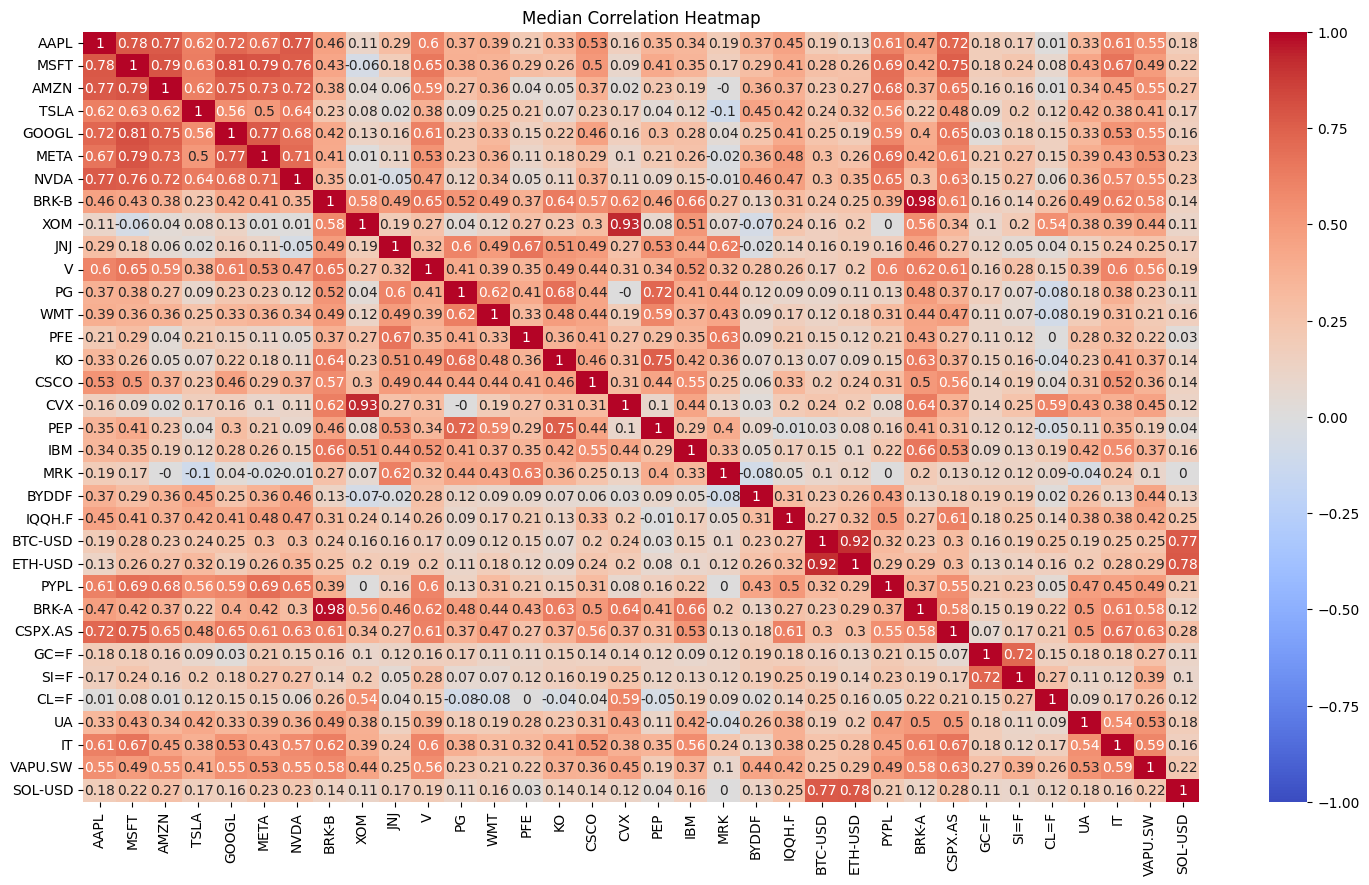

AAPL  MSFT  AMZN  TSLA  GOOGL  META  NVDA  BRK-B   XOM   JNJ  ...  \
AAPL     1.00  0.78  0.77  0.62   0.72  0.67  0.77   0.46  0.11  0.29  ...   
MSFT     0.78  1.00  0.79  0.63   0.81  0.79  0.76   0.43 -0.06  0.18  ...   
AMZN     0.77  0.79  1.00  0.62   0.75  0.73  0.72   0.38  0.04  0.06  ...   
TSLA     0.62  0.63  0.62  1.00   0.56  0.50  0.64   0.23  0.08  0.02  ...   
GOOGL    0.72  0.81  0.75  0.56   1.00  0.77  0.68   0.42  0.13  0.16  ...   
META     0.67  0.79  0.73  0.50   0.77  1.00  0.71   0.41  0.01  0.11  ...   
NVDA     0.77  0.76  0.72  0.64   0.68  0.71  1.00   0.35  0.01 -0.05  ...   
BRK-B    0.46  0.43  0.38  0.23   0.42  0.41  0.35   1.00  0.58  0.49  ...   
XOM      0.11 -0.06  0.04  0.08   0.13  0.01  0.01   0.58  1.00  0.19  ...   
JNJ      0.29  0.18  0.06  0.02   0.16  0.11 -0.05   0.49  0.19  1.00  ...   
V        0.60  0.65  0.59  0.38   0.61  0.53  0.47   0.65  0.27  0.32  ...   
PG       0.37  0.38  0.27  0.09   0.23  0.23  0.12   0.52  0.04  0.60  ...   
WMT      0.39  0.36  0.36  0.25   0.33  0.36  0.34   0.49  0.12  0.49  ...   
PFE      0.21  0.29  0.04  0.21   0.15  0.11  0.05   0.37  0.27  0.67  ...   
KO       0.33  0.26  0.05  0.07   0.22  0.18  0.11   0.64  0.23  0.51  ...   
CSCO     0.53  0.50  0.37  0.23   0.46  0.29  0.37   0.57  0.30  0.49  ...   
CVX      0.16  0.09  0.02  0.17   0.16  0.10  0.11   0.62  0.93  0.27  ...   
PEP      0.35  0.41  0.23  0.04   0.30  0.21  0.09   0.46  0.08  0.53  ...   
IBM      0.34  0.35  0.19  0.12   0.28  0.26  0.15   0.66  0.51  0.44  ...   
MRK      0.19  0.17 -0.00 -0.10   0.04 -0.02 -0.01   0.27  0.07  0.62  ...   
BYDDF    0.37  0.29  0.36  0.45   0.25  0.36  0.46   0.13 -0.07 -0.02  ...   
IQQH.F   0.45  0.41  0.37  0.42   0.41  0.48  0.47   0.31  0.24  0.14  ...   
BTC-USD  0.19  0.28  0.23  0.24   0.25  0.30  0.30   0.24  0.16  0.16  ...   
ETH-USD  0.13  0.26  0.27  0.32   0.19  0.26  0.35   0.25  0.20  0.19  ...   
PYPL     0.61  0.69  0.68  0.56   0.59  0.69  0.65   0.39  0.00  0.16  ...   
BRK-A    0.47  0.42  0.37  0.22   0.40  0.42  0.30   0.98  0.56  0.46  ...   
CSPX.AS  0.72  0.75  0.65  0.48   0.65  0.61  0.63   0.61  0.34  0.27  ...   
GC=F     0.18  0.18  0.16  0.09   0.03  0.21  0.15   0.16  0.10  0.12  ...   
SI=F     0.17  0.24  0.16  0.20   0.18  0.27  0.27   0.14  0.20  0.05  ...   
CL=F     0.01  0.08  0.01  0.12   0.15  0.15  0.06   0.26  0.54  0.04  ...   
UA       0.33  0.43  0.34  0.42   0.33  0.39  0.36   0.49  0.38  0.15  ...   
IT       0.61  0.67  0.45  0.38   0.53  0.43  0.57   0.62  0.39  0.24  ...   
VAPU.SW  0.55  0.49  0.55  0.41   0.55  0.53  0.55   0.58  0.44  0.25  ...   
SOL-USD  0.18  0.22  0.27  0.17   0.16  0.23  0.23   0.14  0.11  0.17  ...   

         PYPL  BRK-A  CSPX.AS  GC=F  SI=F  CL=F    UA    IT  VAPU.SW  SOL-USD  
AAPL     0.61   0.47     0.72  0.18  0.17  0.01  0.33  0.61     0.55     0.18  
MSFT     0.69   0.42     0.75  0.18  0.24  0.08  0.43  0.67     0.49     0.22  
AMZN     0.68   0.37     0.65  0.16  0.16  0.01  0.34  0.45     0.55     0.27  
TSLA     0.56   0.22     0.48  0.09  0.20  0.12  0.42  0.38     0.41     0.17  
GOOGL    0.59   0.40     0.65  0.03  0.18  0.15  0.33  0.53     0.55     0.16  
META     0.69   0.42     0.61  0.21  0.27  0.15  0.39  0.43     0.53     0.23  
NVDA     0.65   0.30     0.63  0.15  0.27  0.06  0.36  0.57     0.55     0.23  
BRK-B    0.39   0.98     0.61  0.16  0.14  0.26  0.49  0.62     0.58     0.14  
XOM      0.00   0.56     0.34  0.10  0.20  0.54  0.38  0.39     0.44     0.11  
JNJ      0.16   0.46     0.27  0.12  0.05  0.04  0.15  0.24     0.25     0.17  
V        0.60   0.62     0.61  0.16  0.28  0.15  0.39  0.60     0.56     0.19  
PG       0.13   0.48     0.37  0.17  0.07 -0.08  0.18  0.38     0.23     0.11  
WMT      0.31   0.44     0.47  0.11  0.07 -0.08  0.19  0.31     0.21     0.16  
PFE      0.21   0.43     0.27  0.11  0.12  0.00  0.28  0.32     0.22     0.03  
KO       0.15   0.63     0.37  0.15  0.16 -0.04  0.23  0.41     0.37     0.14 

In [31]:
# Weekly correlation matrix heatmap
weekly_median_corr_matrix = plot_median_correlation_heatmap(cleaned_data, weekly_correlations)
# Weekly correlation matrix
weekly_median_corr_matrix

In [32]:
# Check for normal distribution and plot histograms
#check_normal_distribution_and_plot(weekly_correlations)

In [33]:
# Find the best combinations
# Top n options
top_n = 5
best_combinations_weekly = find_best_stock_combinations(weekly_median_corr_matrix, normalized_slopes_df, categorized_stocks, num_stocks=4, top_n=top_n)

# Display the best combinations
for idx, (combo, median_corr, median_slope) in enumerate(best_combinations_weekly, start=1):
    print(f"Combination {idx}: Stocks: {combo}, Median Correlation: {median_corr:.3f}, Median Slope: {median_slope:.4f}")

Combination 1: Stocks: ['XOM', 'MRK', 'NVDA', 'META'], Median Correlation: 0.015, Median Slope: 0.0007
Combination 2: Stocks: ['AAPL', 'BYDDF', 'CL=F', 'JNJ'], Median Correlation: 0.030, Median Slope: 0.0003
Combination 3: Stocks: ['CVX', 'BYDDF', 'CL=F', 'JNJ'], Median Correlation: 0.035, Median Slope: 0.0003
Combination 4: Stocks: ['XOM', 'MRK', 'NVDA', 'SOL-USD'], Median Correlation: 0.040, Median Slope: 0.0007
Combination 5: Stocks: ['KO', 'BYDDF', 'CL=F', 'JNJ'], Median Correlation: 0.040, Median Slope: 0.0003


### Calculating the total weekly value

In [34]:
# Calculate total values
total_value_weekly = calculate_investment_value(cleaned_data, best_combinations_weekly, purchase_date, investment_amount)
#total_value_weekly

Purchase date: 2020-12-30, Last date: 2024-07-31
Assets: ['XOM', 'MRK', 'NVDA', 'META'], Individual values: {'XOM': '289.47', 'MRK': '148.87', 'NVDA': '869.11', 'META': '169.46'}, Total value: 1476.92
Assets: ['AAPL', 'BYDDF', 'CL=F', 'JNJ'], Individual values: {'AAPL': '163.33', 'BYDDF': '111.65', 'CL=F': '156.33', 'JNJ': '103.30'}, Total value: 534.61
Assets: ['CVX', 'BYDDF', 'CL=F', 'JNJ'], Individual values: {'CVX': '191.10', 'BYDDF': '111.65', 'CL=F': '156.33', 'JNJ': '103.30'}, Total value: 562.38
Assets: ['XOM', 'MRK', 'NVDA', 'SOL-USD'], Individual values: {'XOM': '289.47', 'MRK': '148.87', 'NVDA': '869.11', 'SOL-USD': '10727.00'}, Total value: 12034.46
Assets: ['KO', 'BYDDF', 'CL=F', 'JNJ'], Individual values: {'KO': '124.88', 'BYDDF': '111.65', 'CL=F': '156.33', 'JNJ': '103.30'}, Total value: 496.16


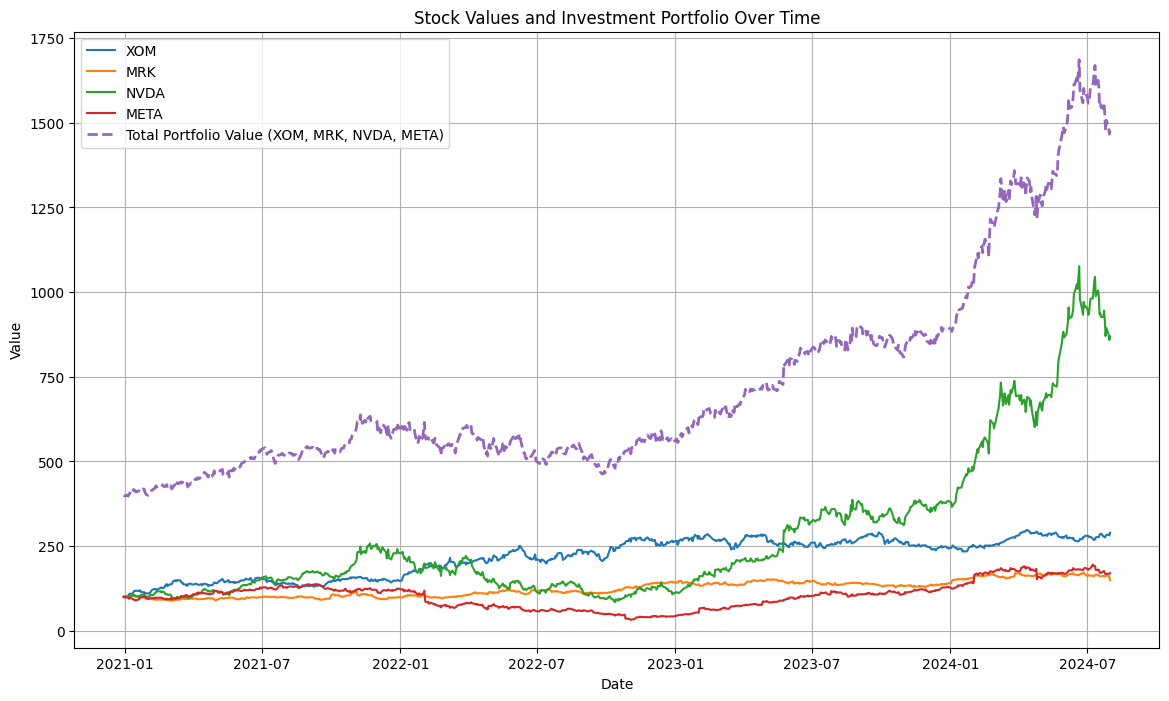

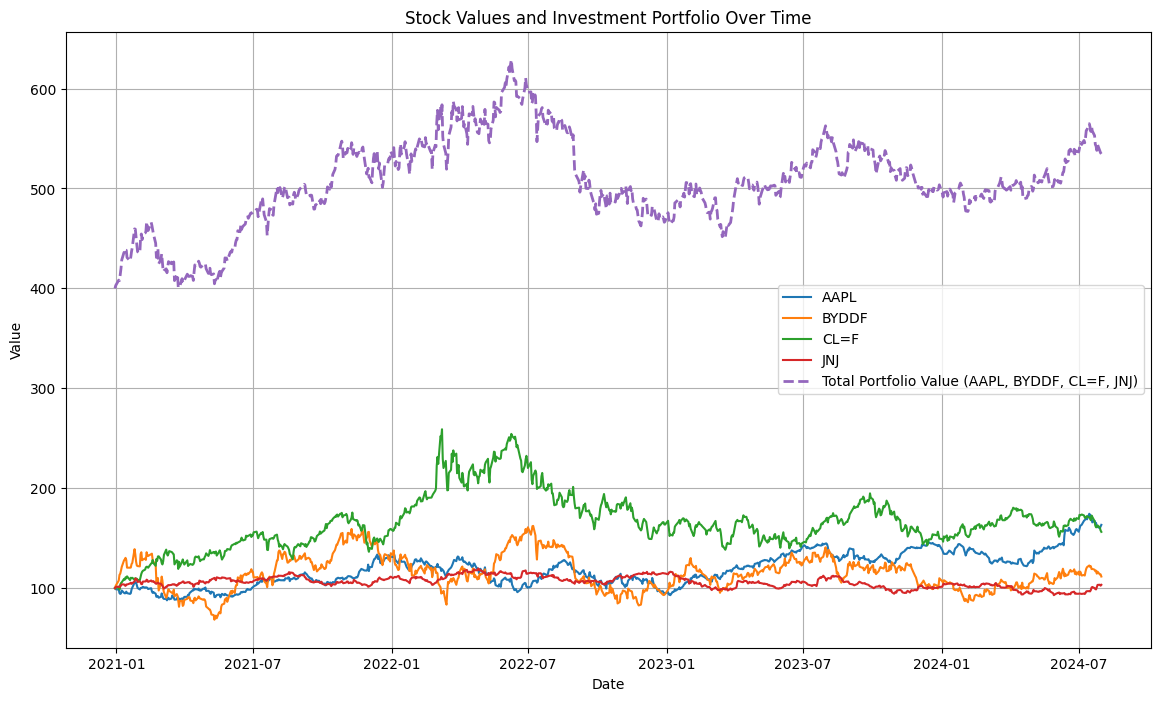

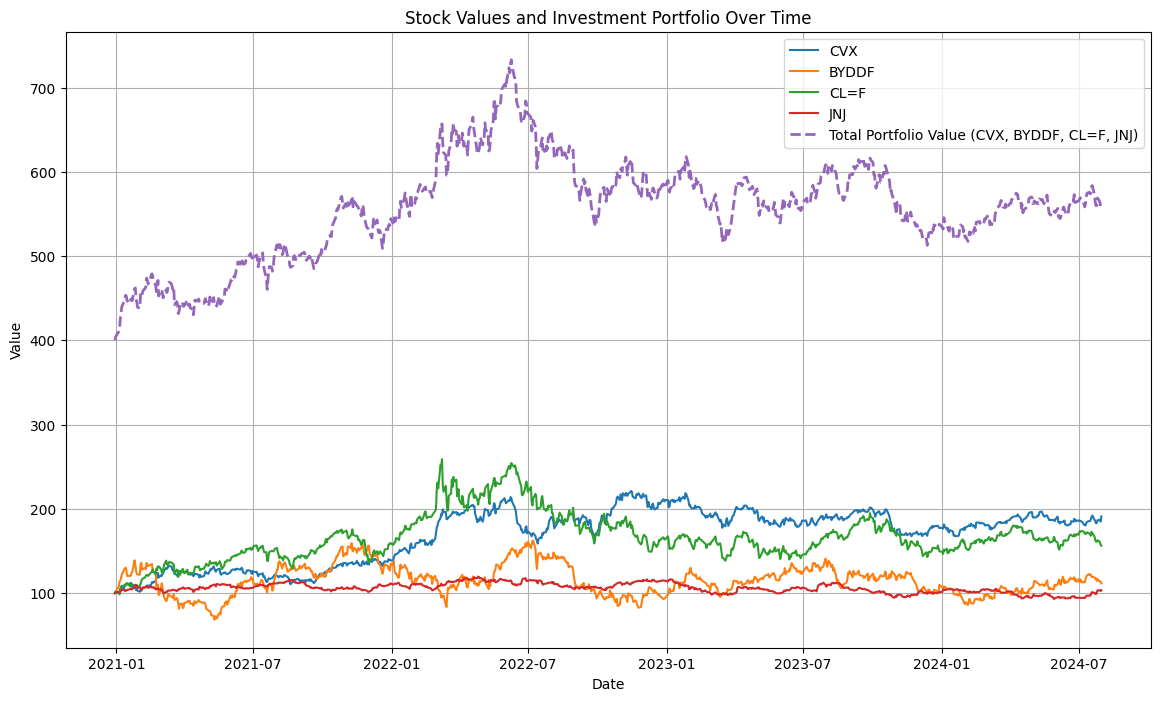

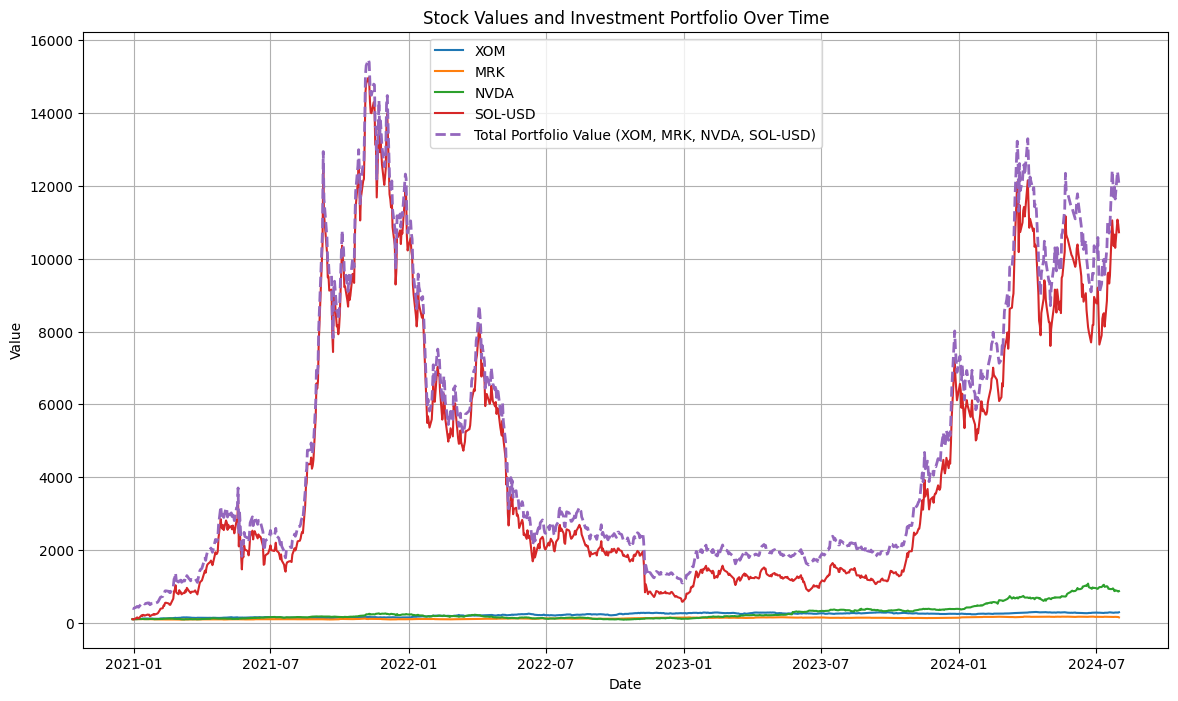

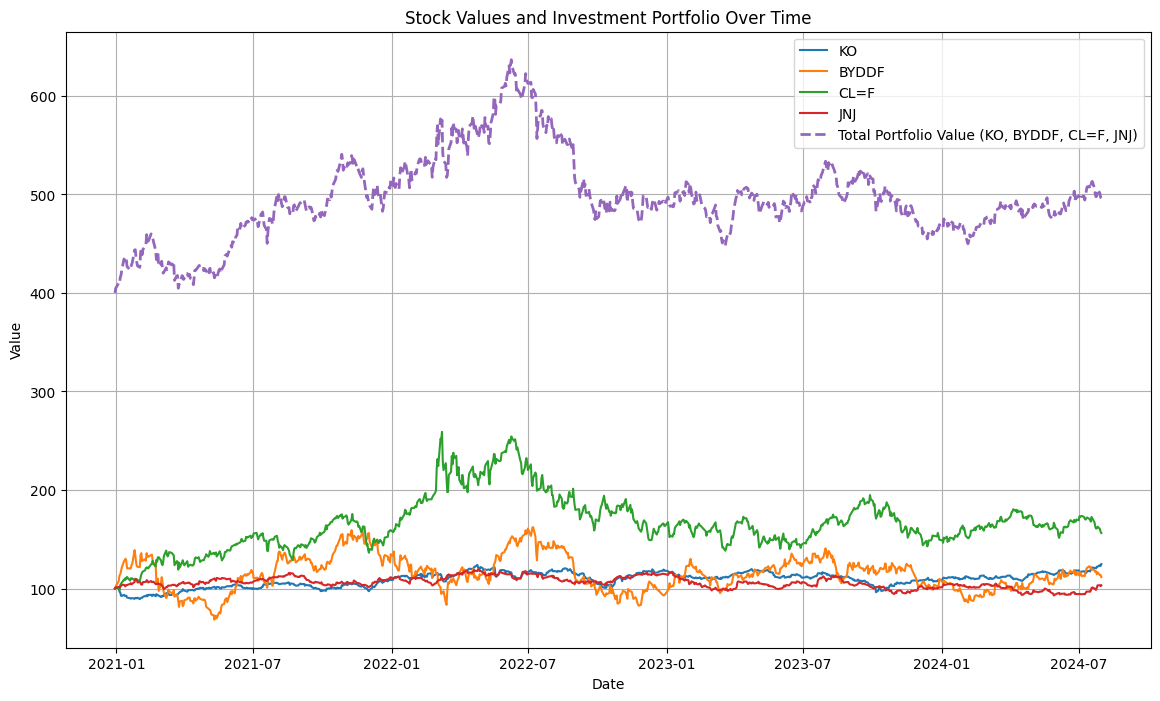

In [35]:
visualize_portfolio(cleaned_data, purchase_date, best_combinations_weekly, investment_amount)

## Monthly analysis

In [ ]:
# Monthly correlations calculate
monthly_correlations = calculate_correlations(cleaned_data, start_date, end_date, frequency='monthly')

# Show
#monthly_correlations

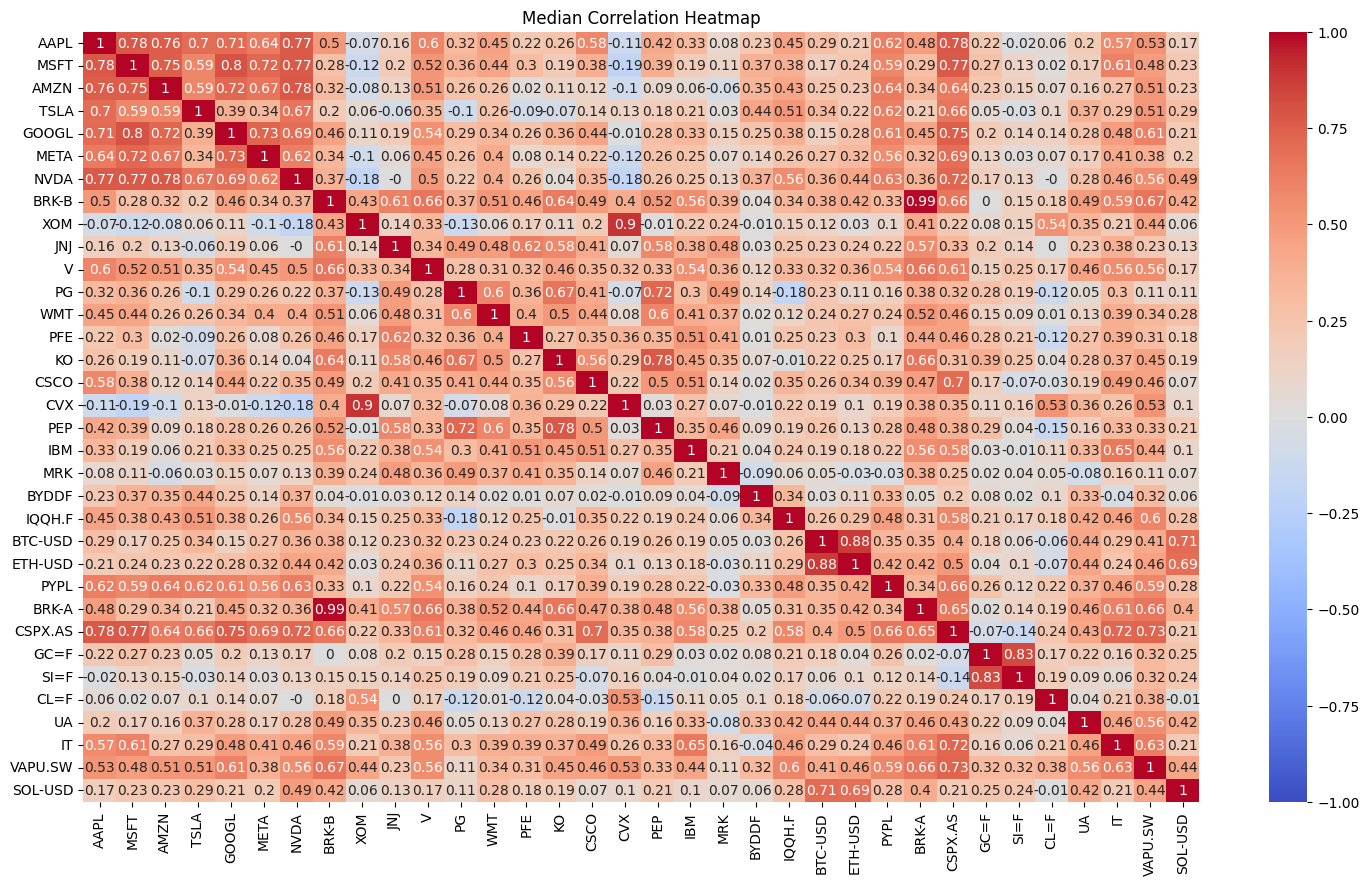

AAPL  MSFT  AMZN  TSLA  GOOGL  META  NVDA  BRK-B   XOM   JNJ  ...  \
AAPL     1.00  0.78  0.76  0.70   0.71  0.64  0.77   0.50 -0.07  0.16  ...   
MSFT     0.78  1.00  0.75  0.59   0.80  0.72  0.77   0.28 -0.12  0.20  ...   
AMZN     0.76  0.75  1.00  0.59   0.72  0.67  0.78   0.32 -0.08  0.13  ...   
TSLA     0.70  0.59  0.59  1.00   0.39  0.34  0.67   0.20  0.06 -0.06  ...   
GOOGL    0.71  0.80  0.72  0.39   1.00  0.73  0.69   0.46  0.11  0.19  ...   
META     0.64  0.72  0.67  0.34   0.73  1.00  0.62   0.34 -0.10  0.06  ...   
NVDA     0.77  0.77  0.78  0.67   0.69  0.62  1.00   0.37 -0.18 -0.00  ...   
BRK-B    0.50  0.28  0.32  0.20   0.46  0.34  0.37   1.00  0.43  0.61  ...   
XOM     -0.07 -0.12 -0.08  0.06   0.11 -0.10 -0.18   0.43  1.00  0.14  ...   
JNJ      0.16  0.20  0.13 -0.06   0.19  0.06 -0.00   0.61  0.14  1.00  ...   
V        0.60  0.52  0.51  0.35   0.54  0.45  0.50   0.66  0.33  0.34  ...   
PG       0.32  0.36  0.26 -0.10   0.29  0.26  0.22   0.37 -0.13  0.49  ...   
WMT      0.45  0.44  0.26  0.26   0.34  0.40  0.40   0.51  0.06  0.48  ...   
PFE      0.22  0.30  0.02 -0.09   0.26  0.08  0.26   0.46  0.17  0.62  ...   
KO       0.26  0.19  0.11 -0.07   0.36  0.14  0.04   0.64  0.11  0.58  ...   
CSCO     0.58  0.38  0.12  0.14   0.44  0.22  0.35   0.49  0.20  0.41  ...   
CVX     -0.11 -0.19 -0.10  0.13  -0.01 -0.12 -0.18   0.40  0.90  0.07  ...   
PEP      0.42  0.39  0.09  0.18   0.28  0.26  0.26   0.52 -0.01  0.58  ...   
IBM      0.33  0.19  0.06  0.21   0.33  0.25  0.25   0.56  0.22  0.38  ...   
MRK      0.08  0.11 -0.06  0.03   0.15  0.07  0.13   0.39  0.24  0.48  ...   
BYDDF    0.23  0.37  0.35  0.44   0.25  0.14  0.37   0.04 -0.01  0.03  ...   
IQQH.F   0.45  0.38  0.43  0.51   0.38  0.26  0.56   0.34  0.15  0.25  ...   
BTC-USD  0.29  0.17  0.25  0.34   0.15  0.27  0.36   0.38  0.12  0.23  ...   
ETH-USD  0.21  0.24  0.23  0.22   0.28  0.32  0.44   0.42  0.03  0.24  ...   
PYPL     0.62  0.59  0.64  0.62   0.61  0.56  0.63   0.33  0.10  0.22  ...   
BRK-A    0.48  0.29  0.34  0.21   0.45  0.32  0.36   0.99  0.41  0.57  ...   
CSPX.AS  0.78  0.77  0.64  0.66   0.75  0.69  0.72   0.66  0.22  0.33  ...   
GC=F     0.22  0.27  0.23  0.05   0.20  0.13  0.17   0.00  0.08  0.20  ...   
SI=F    -0.02  0.13  0.15 -0.03   0.14  0.03  0.13   0.15  0.15  0.14  ...   
CL=F     0.06  0.02  0.07  0.10   0.14  0.07 -0.00   0.18  0.54  0.00  ...   
UA       0.20  0.17  0.16  0.37   0.28  0.17  0.28   0.49  0.35  0.23  ...   
IT       0.57  0.61  0.27  0.29   0.48  0.41  0.46   0.59  0.21  0.38  ...   
VAPU.SW  0.53  0.48  0.51  0.51   0.61  0.38  0.56   0.67  0.44  0.23  ...   
SOL-USD  0.17  0.23  0.23  0.29   0.21  0.20  0.49   0.42  0.06  0.13  ...   

         PYPL  BRK-A  CSPX.AS  GC=F  SI=F  CL=F    UA    IT  VAPU.SW  SOL-USD  
AAPL     0.62   0.48     0.78  0.22 -0.02  0.06  0.20  0.57     0.53     0.17  
MSFT     0.59   0.29     0.77  0.27  0.13  0.02  0.17  0.61     0.48     0.23  
AMZN     0.64   0.34     0.64  0.23  0.15  0.07  0.16  0.27     0.51     0.23  
TSLA     0.62   0.21     0.66  0.05 -0.03  0.10  0.37  0.29     0.51     0.29  
GOOGL    0.61   0.45     0.75  0.20  0.14  0.14  0.28  0.48     0.61     0.21  
META     0.56   0.32     0.69  0.13  0.03  0.07  0.17  0.41     0.38     0.20  
NVDA     0.63   0.36     0.72  0.17  0.13 -0.00  0.28  0.46     0.56     0.49  
BRK-B    0.33   0.99     0.66  0.00  0.15  0.18  0.49  0.59     0.67     0.42  
XOM      0.10   0.41     0.22  0.08  0.15  0.54  0.35  0.21     0.44     0.06  
JNJ      0.22   0.57     0.33  0.20  0.14  0.00  0.23  0.38     0.23     0.13  
V        0.54   0.66     0.61  0.15  0.25  0.17  0.46  0.56     0.56     0.17  
PG       0.16   0.38     0.32  0.28  0.19 -0.12  0.05  0.30     0.11     0.11  
WMT      0.24   0.52     0.46  0.15  0.09  0.01  0.13  0.39     0.34     0.28  
PFE      0.10   0.44     0.46  0.28  0.21 -0.12  0.27  0.39     0.31     0.18  
KO       0.17   0.66     0.31  0.39  0.25  0.04  0.28  0.37     0.45     0.19 

In [37]:
# Monthly correlation matrix heatmap
monthly_median_corr_matrix = plot_median_correlation_heatmap(cleaned_data, monthly_correlations)
# Monthly correlation matrix
monthly_median_corr_matrix

In [38]:
# Check for normal distribution and plot histograms
#check_normal_distribution_and_plot(monthly_correlations)

In [39]:
# Find the best combinations
# Top n options
top_n = 5
best_combinations_monthly = find_best_stock_combinations(monthly_median_corr_matrix, normalized_slopes_df, categorized_stocks, num_stocks=4, top_n=top_n)

# Display the best combinations
for idx, (combo, median_corr, median_slope) in enumerate(best_combinations_monthly, start=1):
    print(f"Combination {idx}: Stocks: {combo}, Median Correlation: {median_corr:.3f}, Median Slope: {median_slope:.4f}")

Combination 1: Stocks: ['NVDA', 'WMT', 'CL=F', 'JNJ'], Median Correlation: 0.005, Median Slope: 0.0004
Combination 2: Stocks: ['NVDA', 'SOL-USD', 'CL=F', 'JNJ'], Median Correlation: 0.005, Median Slope: 0.0003
Combination 3: Stocks: ['NVDA', 'BYDDF', 'CL=F', 'JNJ'], Median Correlation: 0.015, Median Slope: 0.0003
Combination 4: Stocks: ['KO', 'NVDA', 'CL=F', 'JNJ'], Median Correlation: 0.020, Median Slope: 0.0004
Combination 5: Stocks: ['WMT', 'BYDDF', 'CL=F', 'CSCO'], Median Correlation: 0.025, Median Slope: 0.0003


### Calculating the total monthly value

In [40]:
# Calculate total values
total_value_monthly = calculate_investment_value(cleaned_data, best_combinations_monthly, purchase_date, investment_amount)
#total_value_monthly

Purchase date: 2020-12-30, Last date: 2024-07-31
Assets: ['NVDA', 'WMT', 'CL=F', 'JNJ'], Individual values: {'NVDA': '869.11', 'WMT': '143.25', 'CL=F': '156.33', 'JNJ': '103.30'}, Total value: 1271.99
Assets: ['NVDA', 'SOL-USD', 'CL=F', 'JNJ'], Individual values: {'NVDA': '869.11', 'SOL-USD': '10727.00', 'CL=F': '156.33', 'JNJ': '103.30'}, Total value: 11855.74
Assets: ['NVDA', 'BYDDF', 'CL=F', 'JNJ'], Individual values: {'NVDA': '869.11', 'BYDDF': '111.65', 'CL=F': '156.33', 'JNJ': '103.30'}, Total value: 1240.39
Assets: ['KO', 'NVDA', 'CL=F', 'JNJ'], Individual values: {'KO': '124.88', 'NVDA': '869.11', 'CL=F': '156.33', 'JNJ': '103.30'}, Total value: 1253.63
Assets: ['WMT', 'BYDDF', 'CL=F', 'CSCO'], Individual values: {'WMT': '143.25', 'BYDDF': '111.65', 'CL=F': '156.33', 'CSCO': '108.20'}, Total value: 519.43


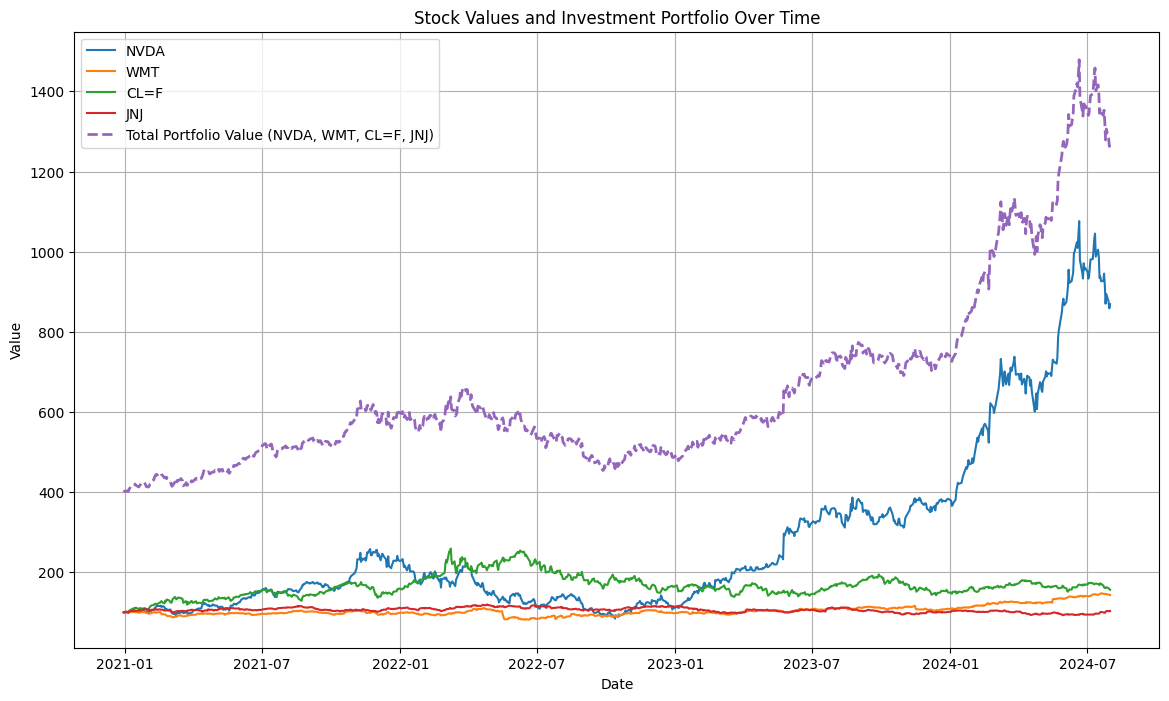

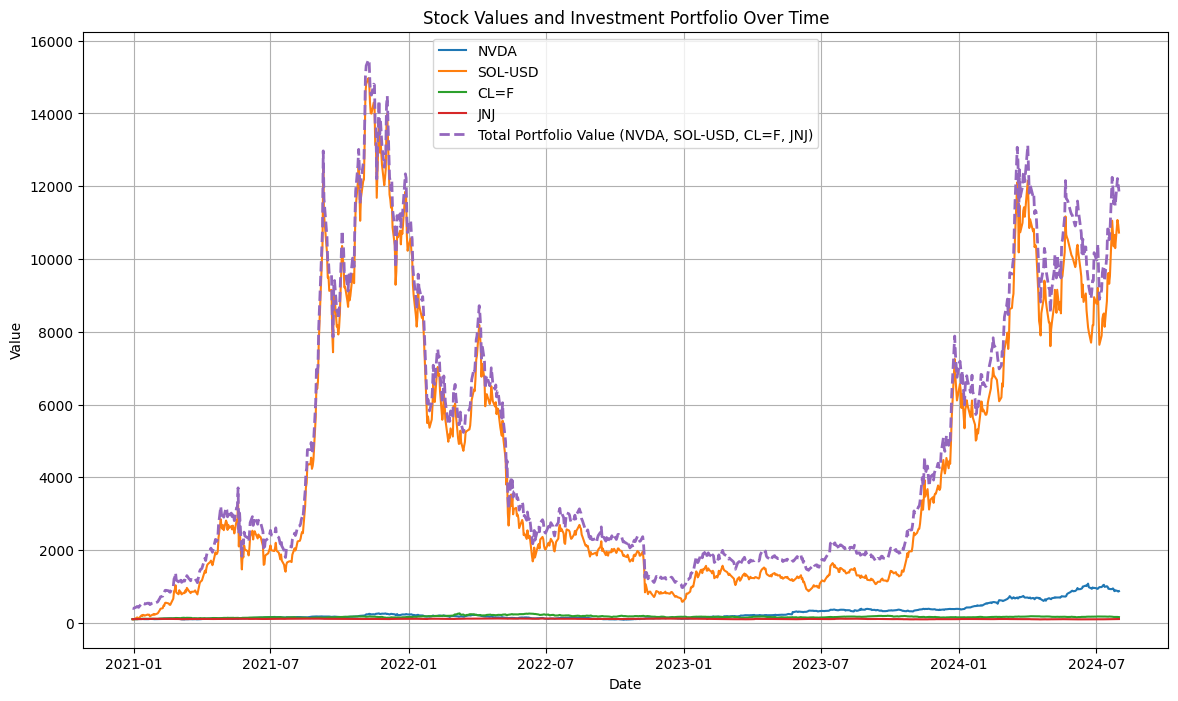

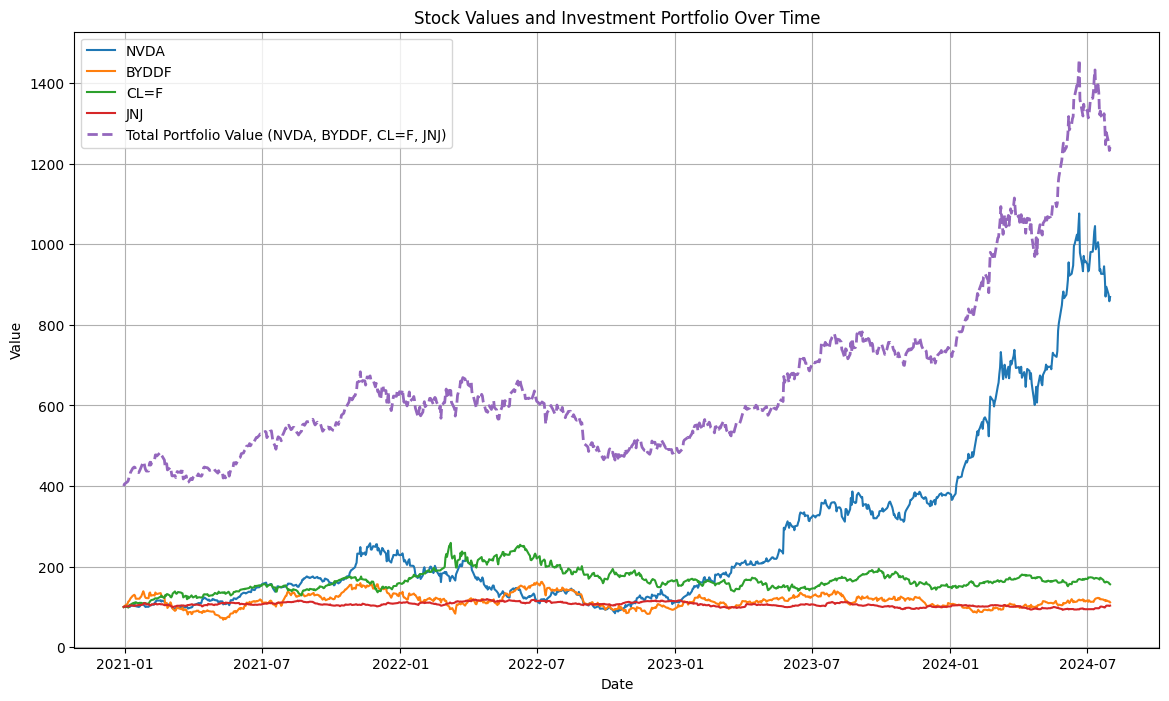

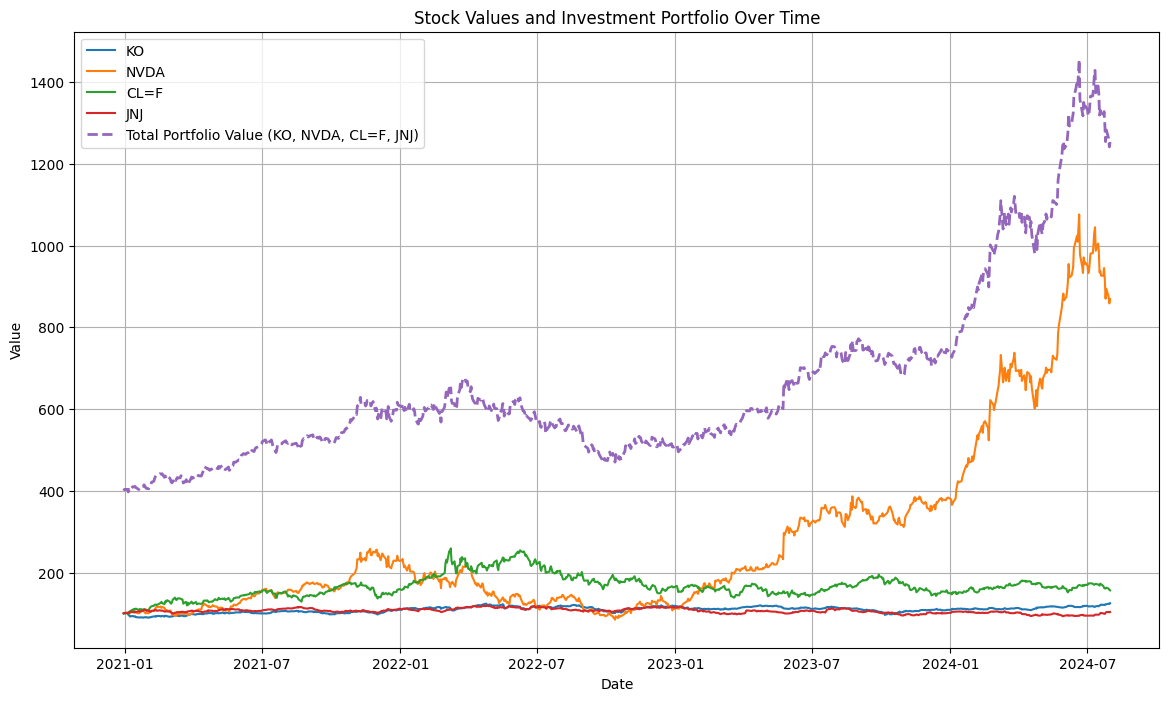

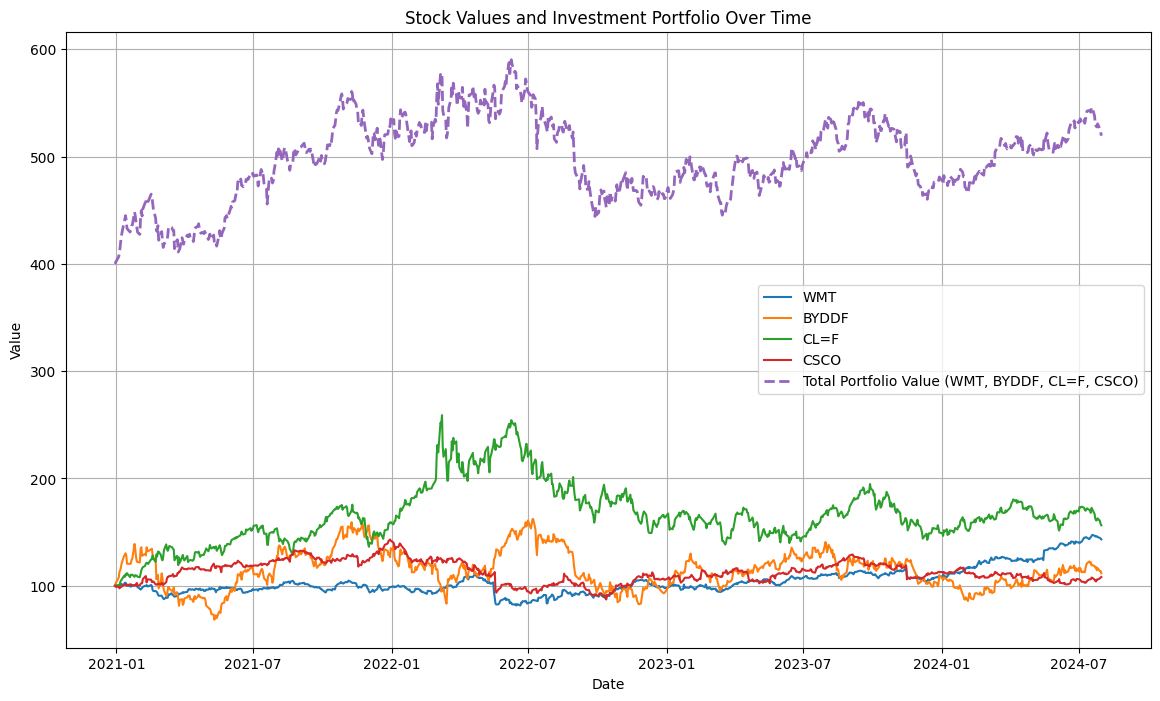

In [41]:
visualize_portfolio(cleaned_data, purchase_date, best_combinations_monthly, investment_amount)

## Quarterly analysis

In [ ]:
# Quarterly correlations calculate
quarterly_correlations = calculate_correlations(cleaned_data, start_date, end_date, frequency='quarterly')

# Show
#quarterly_correlations

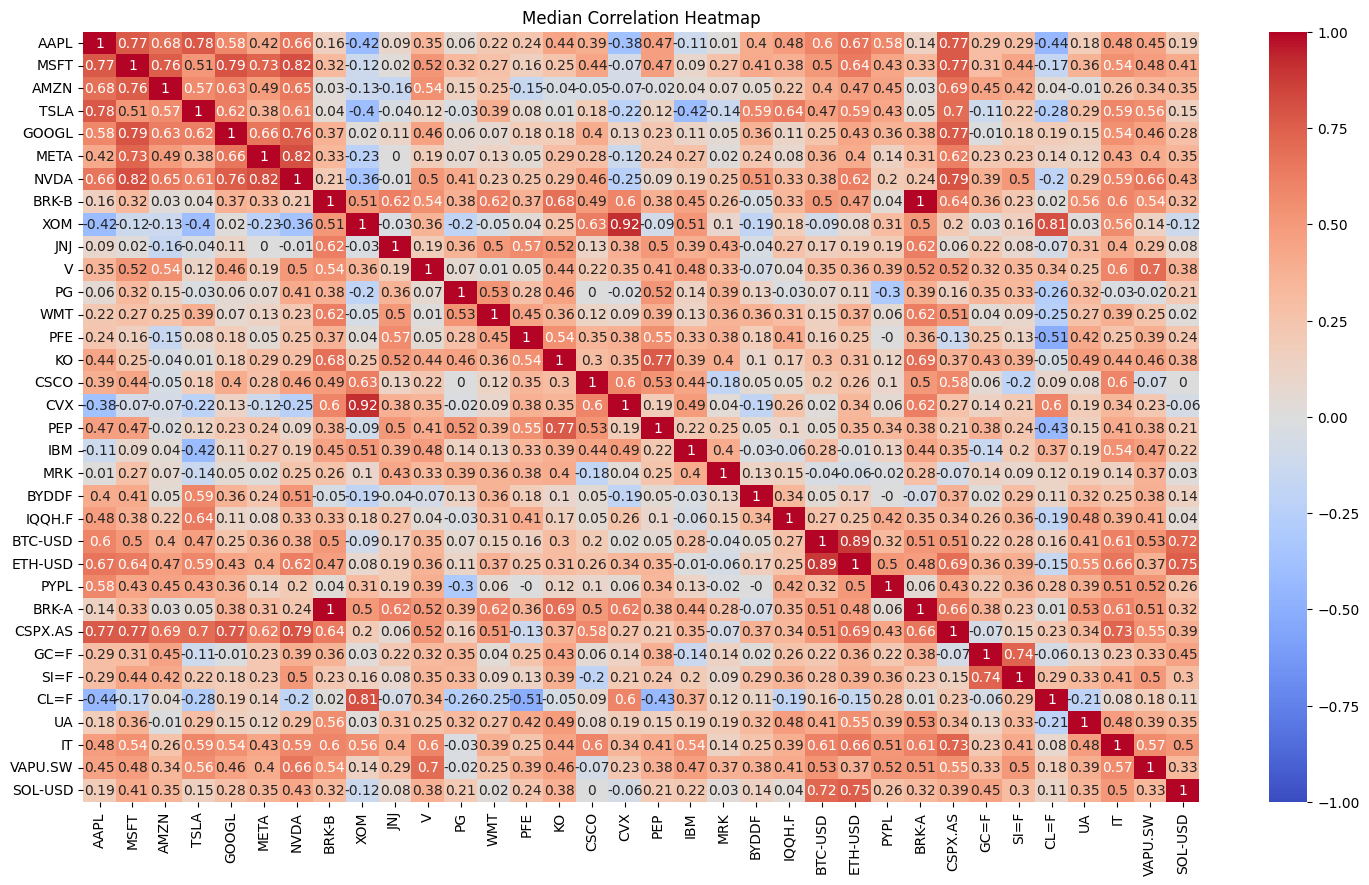

AAPL  MSFT  AMZN  TSLA  GOOGL  META  NVDA  BRK-B   XOM   JNJ  ...  \
AAPL     1.00  0.77  0.68  0.78   0.58  0.42  0.66   0.16 -0.42  0.09  ...   
MSFT     0.77  1.00  0.76  0.51   0.79  0.73  0.82   0.32 -0.12  0.02  ...   
AMZN     0.68  0.76  1.00  0.57   0.63  0.49  0.65   0.03 -0.13 -0.16  ...   
TSLA     0.78  0.51  0.57  1.00   0.62  0.38  0.61   0.04 -0.40 -0.04  ...   
GOOGL    0.58  0.79  0.63  0.62   1.00  0.66  0.76   0.37  0.02  0.11  ...   
META     0.42  0.73  0.49  0.38   0.66  1.00  0.82   0.33 -0.23  0.00  ...   
NVDA     0.66  0.82  0.65  0.61   0.76  0.82  1.00   0.21 -0.36 -0.01  ...   
BRK-B    0.16  0.32  0.03  0.04   0.37  0.33  0.21   1.00  0.51  0.62  ...   
XOM     -0.42 -0.12 -0.13 -0.40   0.02 -0.23 -0.36   0.51  1.00 -0.03  ...   
JNJ      0.09  0.02 -0.16 -0.04   0.11  0.00 -0.01   0.62 -0.03  1.00  ...   
V        0.35  0.52  0.54  0.12   0.46  0.19  0.50   0.54  0.36  0.19  ...   
PG       0.06  0.32  0.15 -0.03   0.06  0.07  0.41   0.38 -0.20  0.36  ...   
WMT      0.22  0.27  0.25  0.39   0.07  0.13  0.23   0.62 -0.05  0.50  ...   
PFE      0.24  0.16 -0.15  0.08   0.18  0.05  0.25   0.37  0.04  0.57  ...   
KO       0.44  0.25 -0.04  0.01   0.18  0.29  0.29   0.68  0.25  0.52  ...   
CSCO     0.39  0.44 -0.05  0.18   0.40  0.28  0.46   0.49  0.63  0.13  ...   
CVX     -0.38 -0.07 -0.07 -0.22   0.13 -0.12 -0.25   0.60  0.92  0.38  ...   
PEP      0.47  0.47 -0.02  0.12   0.23  0.24  0.09   0.38 -0.09  0.50  ...   
IBM     -0.11  0.09  0.04 -0.42   0.11  0.27  0.19   0.45  0.51  0.39  ...   
MRK      0.01  0.27  0.07 -0.14   0.05  0.02  0.25   0.26  0.10  0.43  ...   
BYDDF    0.40  0.41  0.05  0.59   0.36  0.24  0.51  -0.05 -0.19 -0.04  ...   
IQQH.F   0.48  0.38  0.22  0.64   0.11  0.08  0.33   0.33  0.18  0.27  ...   
BTC-USD  0.60  0.50  0.40  0.47   0.25  0.36  0.38   0.50 -0.09  0.17  ...   
ETH-USD  0.67  0.64  0.47  0.59   0.43  0.40  0.62   0.47  0.08  0.19  ...   
PYPL     0.58  0.43  0.45  0.43   0.36  0.14  0.20   0.04  0.31  0.19  ...   
BRK-A    0.14  0.33  0.03  0.05   0.38  0.31  0.24   1.00  0.50  0.62  ...   
CSPX.AS  0.77  0.77  0.69  0.70   0.77  0.62  0.79   0.64  0.20  0.06  ...   
GC=F     0.29  0.31  0.45 -0.11  -0.01  0.23  0.39   0.36  0.03  0.22  ...   
SI=F     0.29  0.44  0.42  0.22   0.18  0.23  0.50   0.23  0.16  0.08  ...   
CL=F    -0.44 -0.17  0.04 -0.28   0.19  0.14 -0.20   0.02  0.81 -0.07  ...   
UA       0.18  0.36 -0.01  0.29   0.15  0.12  0.29   0.56  0.03  0.31  ...   
IT       0.48  0.54  0.26  0.59   0.54  0.43  0.59   0.60  0.56  0.40  ...   
VAPU.SW  0.45  0.48  0.34  0.56   0.46  0.40  0.66   0.54  0.14  0.29  ...   
SOL-USD  0.19  0.41  0.35  0.15   0.28  0.35  0.43   0.32 -0.12  0.08  ...   

         PYPL  BRK-A  CSPX.AS  GC=F  SI=F  CL=F    UA    IT  VAPU.SW  SOL-USD  
AAPL     0.58   0.14     0.77  0.29  0.29 -0.44  0.18  0.48     0.45     0.19  
MSFT     0.43   0.33     0.77  0.31  0.44 -0.17  0.36  0.54     0.48     0.41  
AMZN     0.45   0.03     0.69  0.45  0.42  0.04 -0.01  0.26     0.34     0.35  
TSLA     0.43   0.05     0.70 -0.11  0.22 -0.28  0.29  0.59     0.56     0.15  
GOOGL    0.36   0.38     0.77 -0.01  0.18  0.19  0.15  0.54     0.46     0.28  
META     0.14   0.31     0.62  0.23  0.23  0.14  0.12  0.43     0.40     0.35  
NVDA     0.20   0.24     0.79  0.39  0.50 -0.20  0.29  0.59     0.66     0.43  
BRK-B    0.04   1.00     0.64  0.36  0.23  0.02  0.56  0.60     0.54     0.32  
XOM      0.31   0.50     0.20  0.03  0.16  0.81  0.03  0.56     0.14    -0.12  
JNJ      0.19   0.62     0.06  0.22  0.08 -0.07  0.31  0.40     0.29     0.08  
V        0.39   0.52     0.52  0.32  0.35  0.34  0.25  0.60     0.70     0.38  
PG      -0.30   0.39     0.16  0.35  0.33 -0.26  0.32 -0.03    -0.02     0.21  
WMT      0.06   0.62     0.51  0.04  0.09 -0.25  0.27  0.39     0.25     0.02  
PFE     -0.00   0.36    -0.13  0.25  0.13 -0.51  0.42  0.25     0.39     0.24  
KO       0.12   0.69     0.37  0.43  0.39 -0.05  0.49  0.44     0.46     0.38 

In [43]:
# Quarterly correlation matrix heatmap
quarterly_median_corr_matrix = plot_median_correlation_heatmap(cleaned_data, quarterly_correlations)
# Quarterly correlation matrix
quarterly_median_corr_matrix

In [44]:
# Check for normal distribution and plot histograms
#check_normal_distribution_and_plot(quarterly_correlations)

In [45]:
# Find the best combinations
# Top n options
top_n = 5
best_combinations_quarterly = find_best_stock_combinations(quarterly_median_corr_matrix, normalized_slopes_df, categorized_stocks, num_stocks=4, top_n=top_n)

# Display the best combinations
for idx, (combo, median_corr, median_slope) in enumerate(best_combinations_quarterly, start=1):
    print(f"Combination {idx}: Stocks: {combo}, Median Correlation: {median_corr:.3f}, Median Slope: {median_slope:.4f}")

Combination 1: Stocks: ['XOM', 'GOOGL', 'GC=F', 'BYDDF'], Median Correlation: 0.025, Median Slope: 0.0004
Combination 2: Stocks: ['XOM', 'GOOGL', 'GC=F', 'JNJ'], Median Correlation: 0.030, Median Slope: 0.0004
Combination 3: Stocks: ['XOM', 'GOOGL', 'WMT', 'GC=F'], Median Correlation: 0.035, Median Slope: 0.0005
Combination 4: Stocks: ['XOM', 'GC=F', 'BYDDF', 'JNJ'], Median Correlation: 0.035, Median Slope: 0.0004
Combination 5: Stocks: ['XOM', 'MRK', 'GOOGL', 'GC=F'], Median Correlation: 0.040, Median Slope: 0.0007


### Calculating the total quarterly value

In [46]:
# Calculate total values
total_value_quarterly = calculate_investment_value(cleaned_data, best_combinations_quarterly, purchase_date, investment_amount)
#total_value_quarterly

Purchase date: 2020-12-30, Last date: 2024-07-31
Assets: ['XOM', 'GOOGL', 'GC=F', 'BYDDF'], Individual values: {'XOM': '289.47', 'GOOGL': '196.31', 'GC=F': '128.04', 'BYDDF': '111.65'}, Total value: 725.48
Assets: ['XOM', 'GOOGL', 'GC=F', 'JNJ'], Individual values: {'XOM': '289.47', 'GOOGL': '196.31', 'GC=F': '128.04', 'JNJ': '103.30'}, Total value: 717.13
Assets: ['XOM', 'GOOGL', 'WMT', 'GC=F'], Individual values: {'XOM': '289.47', 'GOOGL': '196.31', 'WMT': '143.25', 'GC=F': '128.04'}, Total value: 757.07
Assets: ['XOM', 'GC=F', 'BYDDF', 'JNJ'], Individual values: {'XOM': '289.47', 'GC=F': '128.04', 'BYDDF': '111.65', 'JNJ': '103.30'}, Total value: 632.47
Assets: ['XOM', 'MRK', 'GOOGL', 'GC=F'], Individual values: {'XOM': '289.47', 'MRK': '148.87', 'GOOGL': '196.31', 'GC=F': '128.04'}, Total value: 762.70


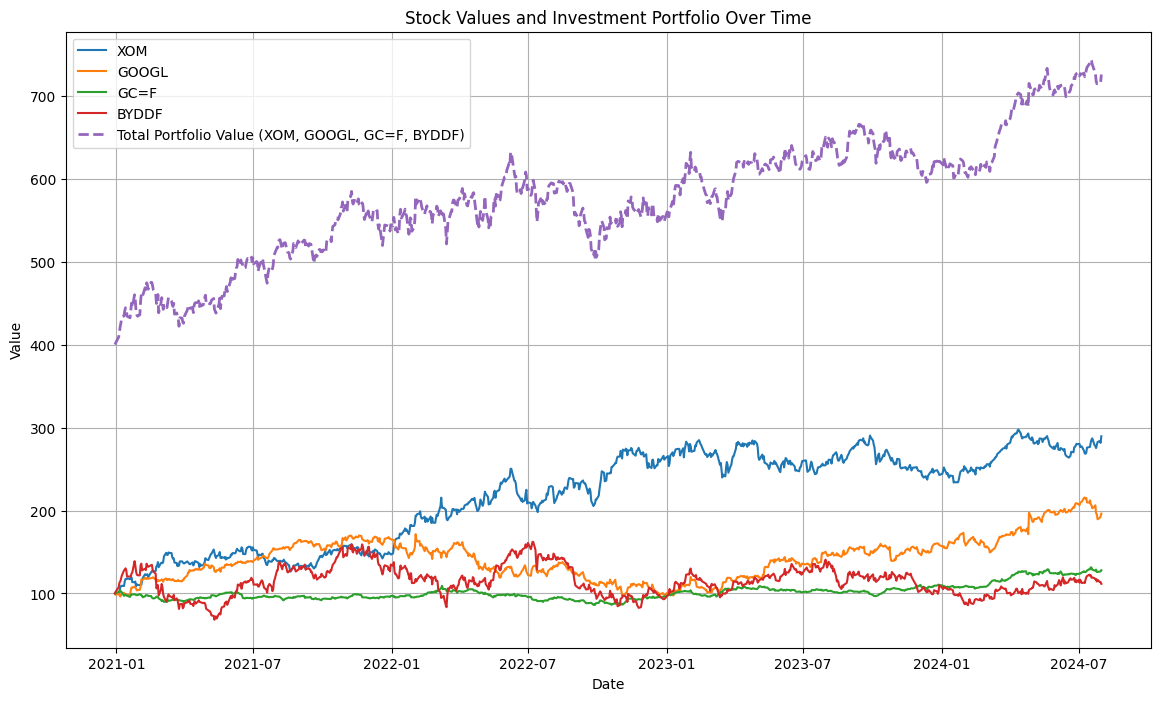

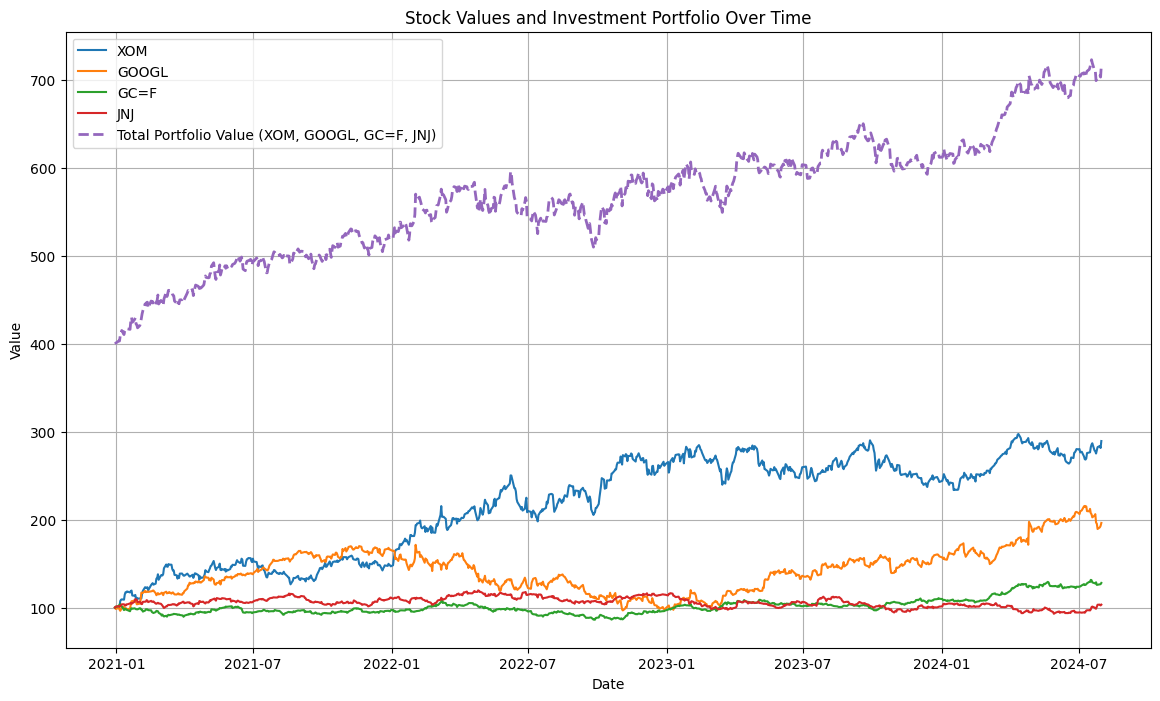

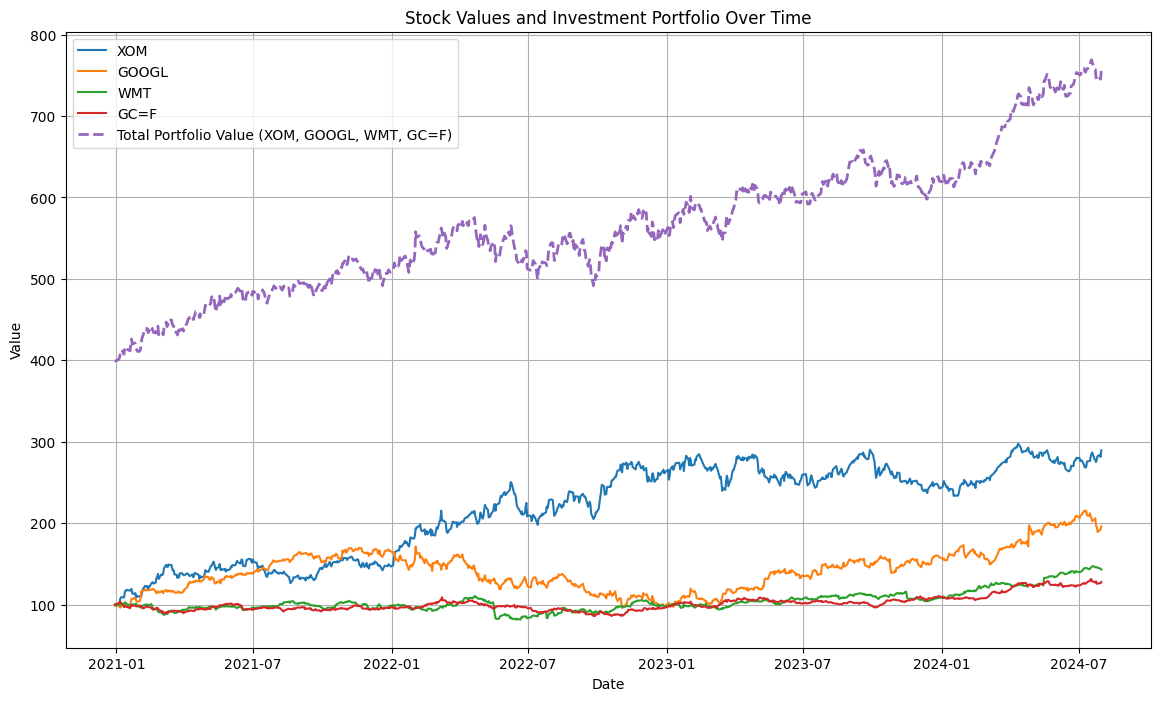

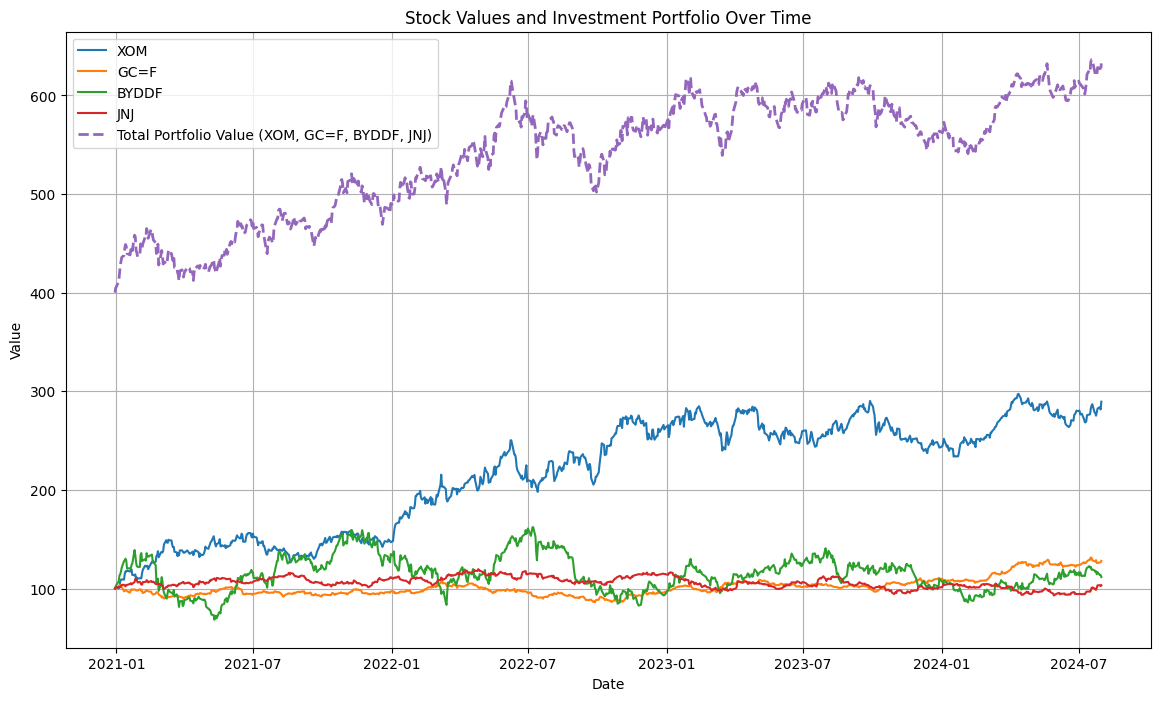

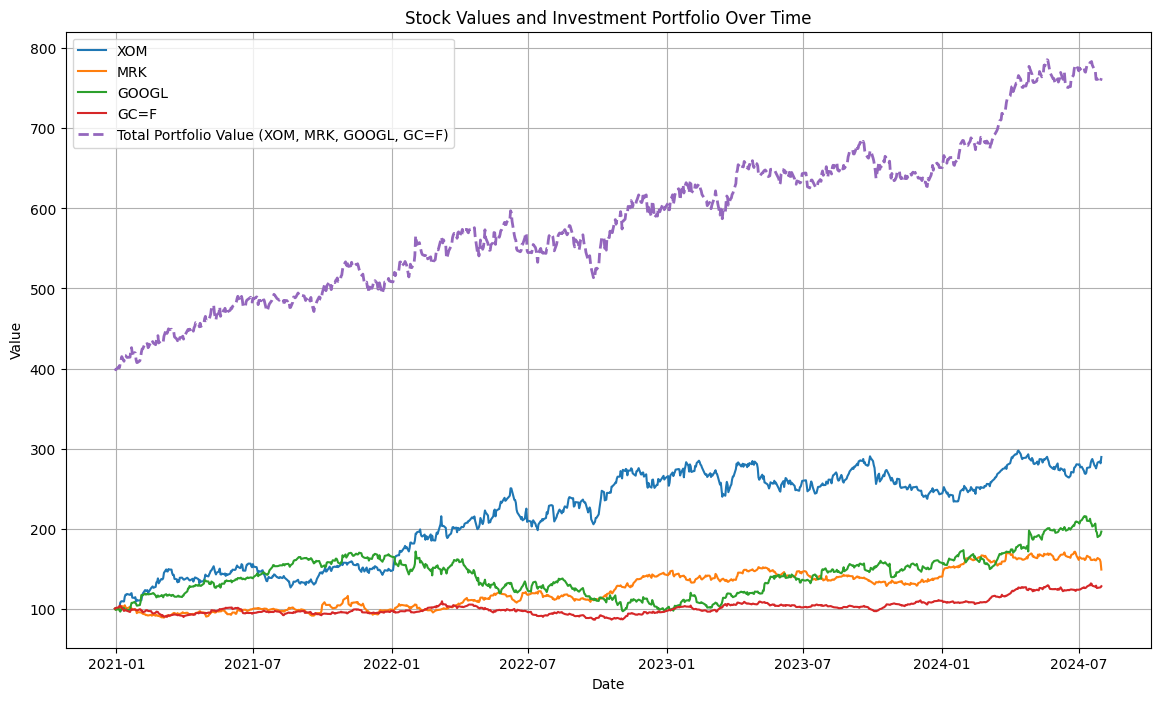

In [47]:
visualize_portfolio(cleaned_data, purchase_date, best_combinations_quarterly, investment_amount)

## Yearly analysis

In [ ]:
# Yearly correlations calculate
yearly_correlations = calculate_correlations(cleaned_data, start_date, end_date, frequency='yearly')

# Show
#yearly_correlations

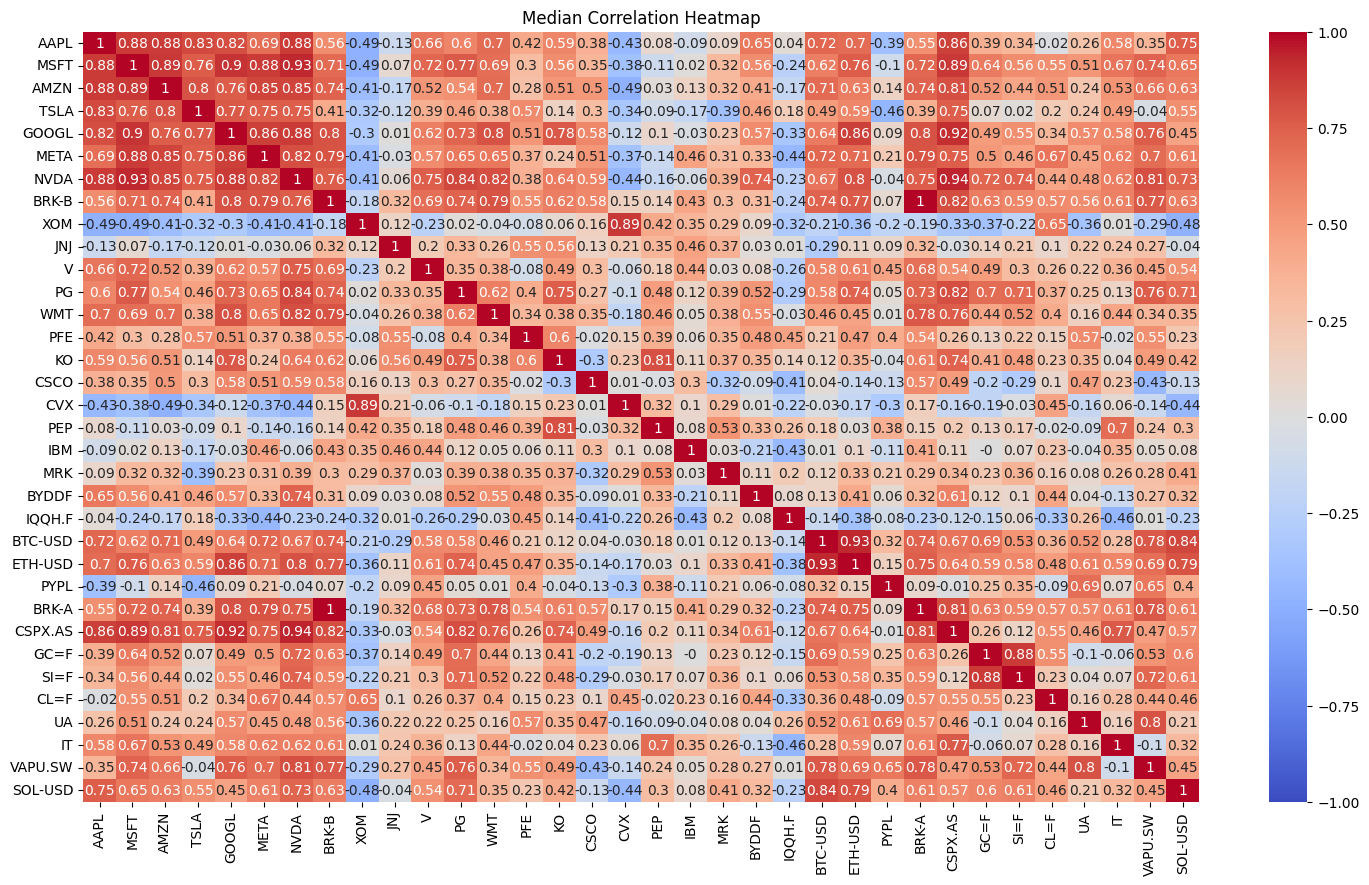

AAPL  MSFT  AMZN  TSLA  GOOGL  META  NVDA  BRK-B   XOM   JNJ  ...  \
AAPL     1.00  0.88  0.88  0.83   0.82  0.69  0.88   0.56 -0.49 -0.13  ...   
MSFT     0.88  1.00  0.89  0.76   0.90  0.88  0.93   0.71 -0.49  0.07  ...   
AMZN     0.88  0.89  1.00  0.80   0.76  0.85  0.85   0.74 -0.41 -0.17  ...   
TSLA     0.83  0.76  0.80  1.00   0.77  0.75  0.75   0.41 -0.32 -0.12  ...   
GOOGL    0.82  0.90  0.76  0.77   1.00  0.86  0.88   0.80 -0.30  0.01  ...   
META     0.69  0.88  0.85  0.75   0.86  1.00  0.82   0.79 -0.41 -0.03  ...   
NVDA     0.88  0.93  0.85  0.75   0.88  0.82  1.00   0.76 -0.41  0.06  ...   
BRK-B    0.56  0.71  0.74  0.41   0.80  0.79  0.76   1.00 -0.18  0.32  ...   
XOM     -0.49 -0.49 -0.41 -0.32  -0.30 -0.41 -0.41  -0.18  1.00  0.12  ...   
JNJ     -0.13  0.07 -0.17 -0.12   0.01 -0.03  0.06   0.32  0.12  1.00  ...   
V        0.66  0.72  0.52  0.39   0.62  0.57  0.75   0.69 -0.23  0.20  ...   
PG       0.60  0.77  0.54  0.46   0.73  0.65  0.84   0.74  0.02  0.33  ...   
WMT      0.70  0.69  0.70  0.38   0.80  0.65  0.82   0.79 -0.04  0.26  ...   
PFE      0.42  0.30  0.28  0.57   0.51  0.37  0.38   0.55 -0.08  0.55  ...   
KO       0.59  0.56  0.51  0.14   0.78  0.24  0.64   0.62  0.06  0.56  ...   
CSCO     0.38  0.35  0.50  0.30   0.58  0.51  0.59   0.58  0.16  0.13  ...   
CVX     -0.43 -0.38 -0.49 -0.34  -0.12 -0.37 -0.44   0.15  0.89  0.21  ...   
PEP      0.08 -0.11  0.03 -0.09   0.10 -0.14 -0.16   0.14  0.42  0.35  ...   
IBM     -0.09  0.02  0.13 -0.17  -0.03  0.46 -0.06   0.43  0.35  0.46  ...   
MRK      0.09  0.32  0.32 -0.39   0.23  0.31  0.39   0.30  0.29  0.37  ...   
BYDDF    0.65  0.56  0.41  0.46   0.57  0.33  0.74   0.31  0.09  0.03  ...   
IQQH.F   0.04 -0.24 -0.17  0.18  -0.33 -0.44 -0.23  -0.24 -0.32  0.01  ...   
BTC-USD  0.72  0.62  0.71  0.49   0.64  0.72  0.67   0.74 -0.21 -0.29  ...   
ETH-USD  0.70  0.76  0.63  0.59   0.86  0.71  0.80   0.77 -0.36  0.11  ...   
PYPL    -0.39 -0.10  0.14 -0.46   0.09  0.21 -0.04   0.07 -0.20  0.09  ...   
BRK-A    0.55  0.72  0.74  0.39   0.80  0.79  0.75   1.00 -0.19  0.32  ...   
CSPX.AS  0.86  0.89  0.81  0.75   0.92  0.75  0.94   0.82 -0.33 -0.03  ...   
GC=F     0.39  0.64  0.52  0.07   0.49  0.50  0.72   0.63 -0.37  0.14  ...   
SI=F     0.34  0.56  0.44  0.02   0.55  0.46  0.74   0.59 -0.22  0.21  ...   
CL=F    -0.02  0.55  0.51  0.20   0.34  0.67  0.44   0.57  0.65  0.10  ...   
UA       0.26  0.51  0.24  0.24   0.57  0.45  0.48   0.56 -0.36  0.22  ...   
IT       0.58  0.67  0.53  0.49   0.58  0.62  0.62   0.61  0.01  0.24  ...   
VAPU.SW  0.35  0.74  0.66 -0.04   0.76  0.70  0.81   0.77 -0.29  0.27  ...   
SOL-USD  0.75  0.65  0.63  0.55   0.45  0.61  0.73   0.63 -0.48 -0.04  ...   

         PYPL  BRK-A  CSPX.AS  GC=F  SI=F  CL=F    UA    IT  VAPU.SW  SOL-USD  
AAPL    -0.39   0.55     0.86  0.39  0.34 -0.02  0.26  0.58     0.35     0.75  
MSFT    -0.10   0.72     0.89  0.64  0.56  0.55  0.51  0.67     0.74     0.65  
AMZN     0.14   0.74     0.81  0.52  0.44  0.51  0.24  0.53     0.66     0.63  
TSLA    -0.46   0.39     0.75  0.07  0.02  0.20  0.24  0.49    -0.04     0.55  
GOOGL    0.09   0.80     0.92  0.49  0.55  0.34  0.57  0.58     0.76     0.45  
META     0.21   0.79     0.75  0.50  0.46  0.67  0.45  0.62     0.70     0.61  
NVDA    -0.04   0.75     0.94  0.72  0.74  0.44  0.48  0.62     0.81     0.73  
BRK-B    0.07   1.00     0.82  0.63  0.59  0.57  0.56  0.61     0.77     0.63  
XOM     -0.20  -0.19    -0.33 -0.37 -0.22  0.65 -0.36  0.01    -0.29    -0.48  
JNJ      0.09   0.32    -0.03  0.14  0.21  0.10  0.22  0.24     0.27    -0.04  
V        0.45   0.68     0.54  0.49  0.30  0.26  0.22  0.36     0.45     0.54  
PG       0.05   0.73     0.82  0.70  0.71  0.37  0.25  0.13     0.76     0.71  
WMT      0.01   0.78     0.76  0.44  0.52  0.40  0.16  0.44     0.34     0.35  
PFE      0.40   0.54     0.26  0.13  0.22  0.15  0.57 -0.02     0.55     0.23  
KO      -0.04   0.61     0.74  0.41  0.48  0.23  0.35  0.04     0.49     0.42 

In [49]:
# Yearly correlation matrix heatmap
yearly_median_corr_matrix = plot_median_correlation_heatmap(cleaned_data, yearly_correlations)
# Yearly correlation matrix
yearly_median_corr_matrix

In [50]:
# Check for normal distribution and plot histograms
#check_normal_distribution_and_plot(yearly_correlations)

In [51]:
# Find the best combinations
# Top n options
top_n = 5
best_combinations_yearly = find_best_stock_combinations(quarterly_median_corr_matrix, normalized_slopes_df, categorized_stocks, num_stocks=4, top_n=top_n)

# Display the best combinations
for idx, (combo, median_corr, median_slope) in enumerate(best_combinations_yearly, start=1):
    print(f"Combination {idx}: Stocks: {combo}, Median Correlation: {median_corr:.3f}, Median Slope: {median_slope:.4f}")

Combination 1: Stocks: ['XOM', 'GOOGL', 'GC=F', 'BYDDF'], Median Correlation: 0.025, Median Slope: 0.0004
Combination 2: Stocks: ['XOM', 'GOOGL', 'GC=F', 'JNJ'], Median Correlation: 0.030, Median Slope: 0.0004
Combination 3: Stocks: ['XOM', 'GOOGL', 'WMT', 'GC=F'], Median Correlation: 0.035, Median Slope: 0.0005
Combination 4: Stocks: ['XOM', 'GC=F', 'BYDDF', 'JNJ'], Median Correlation: 0.035, Median Slope: 0.0004
Combination 5: Stocks: ['XOM', 'MRK', 'GOOGL', 'GC=F'], Median Correlation: 0.040, Median Slope: 0.0007


### Calculating the total yearly value

In [52]:
# Calculate total values
total_value_yearly = calculate_investment_value(cleaned_data, best_combinations_yearly, purchase_date, investment_amount)
#total_value_yearly

Purchase date: 2020-12-30, Last date: 2024-07-31
Assets: ['XOM', 'GOOGL', 'GC=F', 'BYDDF'], Individual values: {'XOM': '289.47', 'GOOGL': '196.31', 'GC=F': '128.04', 'BYDDF': '111.65'}, Total value: 725.48
Assets: ['XOM', 'GOOGL', 'GC=F', 'JNJ'], Individual values: {'XOM': '289.47', 'GOOGL': '196.31', 'GC=F': '128.04', 'JNJ': '103.30'}, Total value: 717.13
Assets: ['XOM', 'GOOGL', 'WMT', 'GC=F'], Individual values: {'XOM': '289.47', 'GOOGL': '196.31', 'WMT': '143.25', 'GC=F': '128.04'}, Total value: 757.07
Assets: ['XOM', 'GC=F', 'BYDDF', 'JNJ'], Individual values: {'XOM': '289.47', 'GC=F': '128.04', 'BYDDF': '111.65', 'JNJ': '103.30'}, Total value: 632.47
Assets: ['XOM', 'MRK', 'GOOGL', 'GC=F'], Individual values: {'XOM': '289.47', 'MRK': '148.87', 'GOOGL': '196.31', 'GC=F': '128.04'}, Total value: 762.70


In [53]:
len(weekly_correlations)

225

In [54]:
len(monthly_correlations)

52

In [55]:
len(quarterly_correlations)

18

In [56]:
len(yearly_correlations)

5

# Vizualization: Plot, Grahp, ect.

In [57]:
def plot_correlation_heatmap(correlation_matrix, tickers):
    """
    Plot a correlation heatmap for the selected tickers.

    Parameters:
    correlation_matrix (pd.DataFrame): DataFrame containing the correlation matrix.
    tickers (list): List of selected tickers to include in the heatmap.

    Returns:
    None: The function will display the heatmap.
    """
    # Filter the correlation matrix for the selected tickers
    filtered_corr_matrix = correlation_matrix.loc[tickers, tickers]
    
    # Plot the heatmap
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5)
    # Move the x-axis labels to the top
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    
    plt.title('Correlation Heatmap', pad=30)
    # Save to png file
    #plt.savefig('correlation_matrix_heatmap.png', bbox_inches='tight')
    plt.show()
    #plt.close()

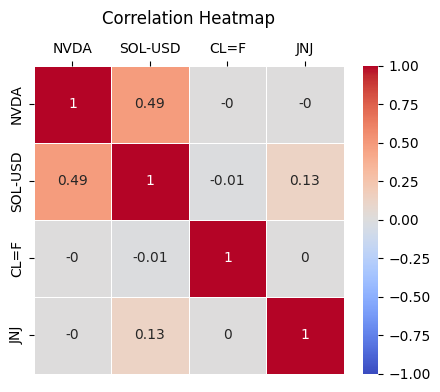

In [58]:
plot_correlation_heatmap(monthly_median_corr_matrix, best_combinations_monthly[1][0])

In [59]:
def save_linear_regression_plots(cleaned_data, stock_names):
    """
    Save linear regression plots for each stock in the cleaned_data DataFrame as image files.
    
    Parameters:
    cleaned_data (pd.DataFrame): The cleaned data DataFrame with stock prices.
    stock_names (dict): Dictionary containing the stock names as keys and the columns to be used in the DataFrame as values.
    output_dir (str): Directory where the plots will be saved.

    Returns:
    None: The function will save the plots as image files.
    """
    
    # Initialize a scaler
    scaler = MinMaxScaler()
    
    # Normalize the data
    normalized_data = pd.DataFrame(scaler.fit_transform(cleaned_data), columns=cleaned_data.columns, index=cleaned_data.index)
    
    for stock in stock_names:
        # Prepare the data for linear regression
        x = np.arange(len(normalized_data))
        y = normalized_data[stock].values
        
        # Fit the linear regression model using np.polyfit
        slope, intercept = np.polyfit(x, y, 1)
        
        # Plot the data and the linear regression line
        plt.figure(figsize=(10, 6))
        plt.plot(normalized_data.index, y, label='Normalized Prices')
        plt.plot(normalized_data.index, slope * x + intercept, label=f'Linear Regression (slope={slope:.4f})', linestyle='--')
        plt.title(f'Linear Regression for {stock}', pad=20)
        plt.xlabel('Date')
        plt.ylabel('Normalized Price')
        plt.legend()
        plt.grid(True)
        
        # Save the plot as an image file with tight bounding box
        #plt.savefig(f"{stock}_linear_regression.png", bbox_inches='tight')
        plt.show()
        #plt.close()

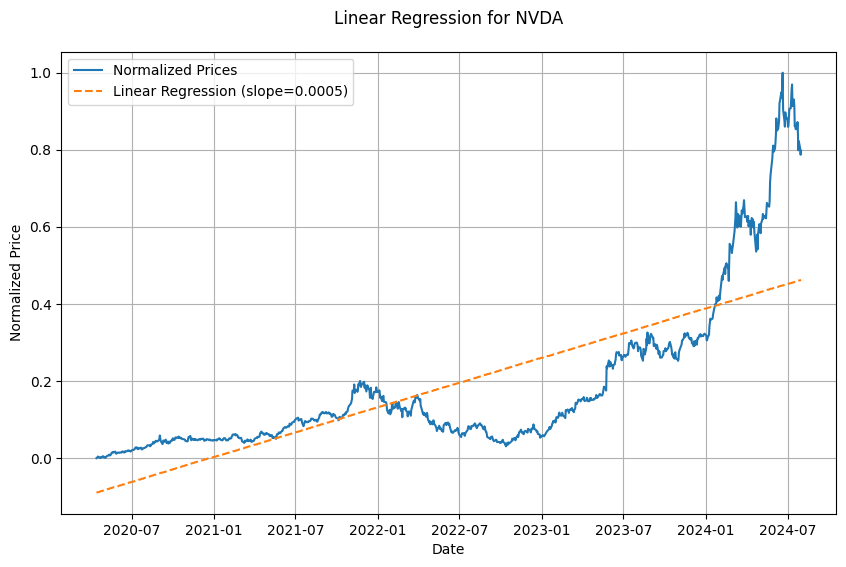

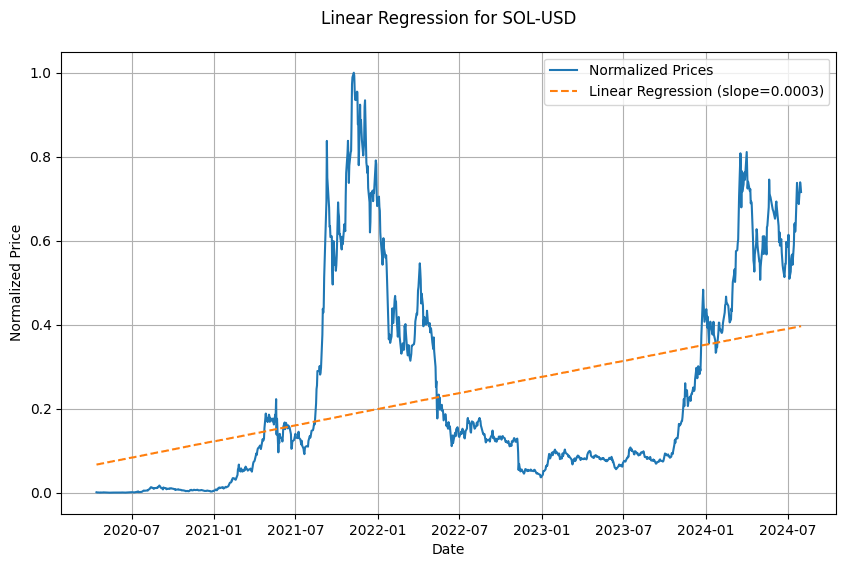

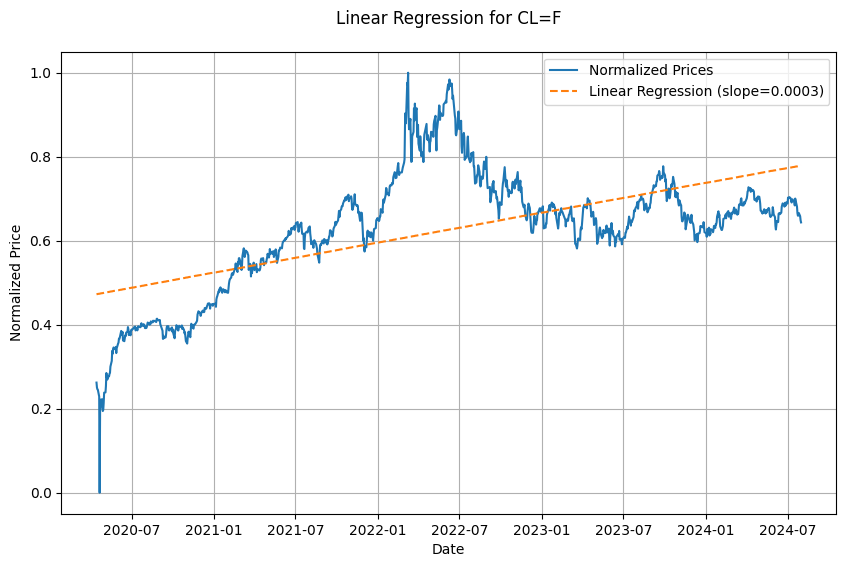

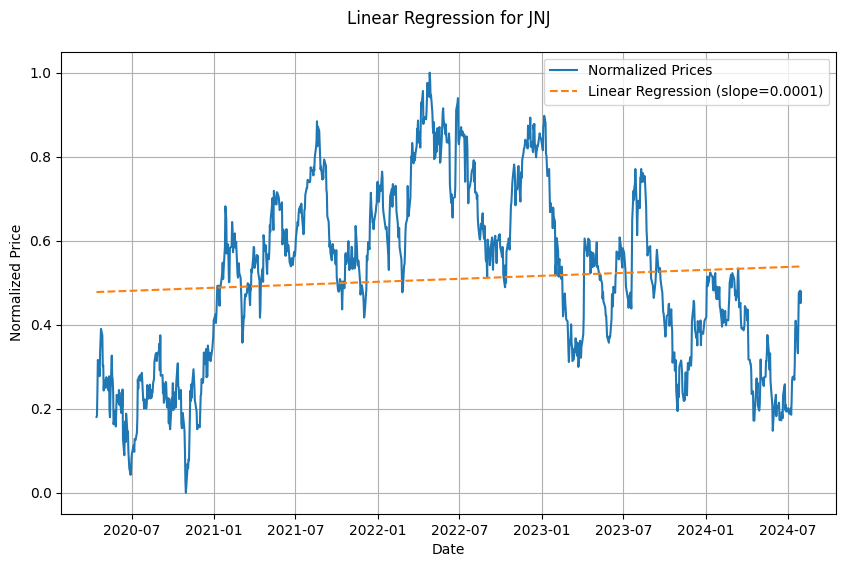

In [60]:
save_linear_regression_plots(cleaned_data, best_combinations_monthly[1][0])

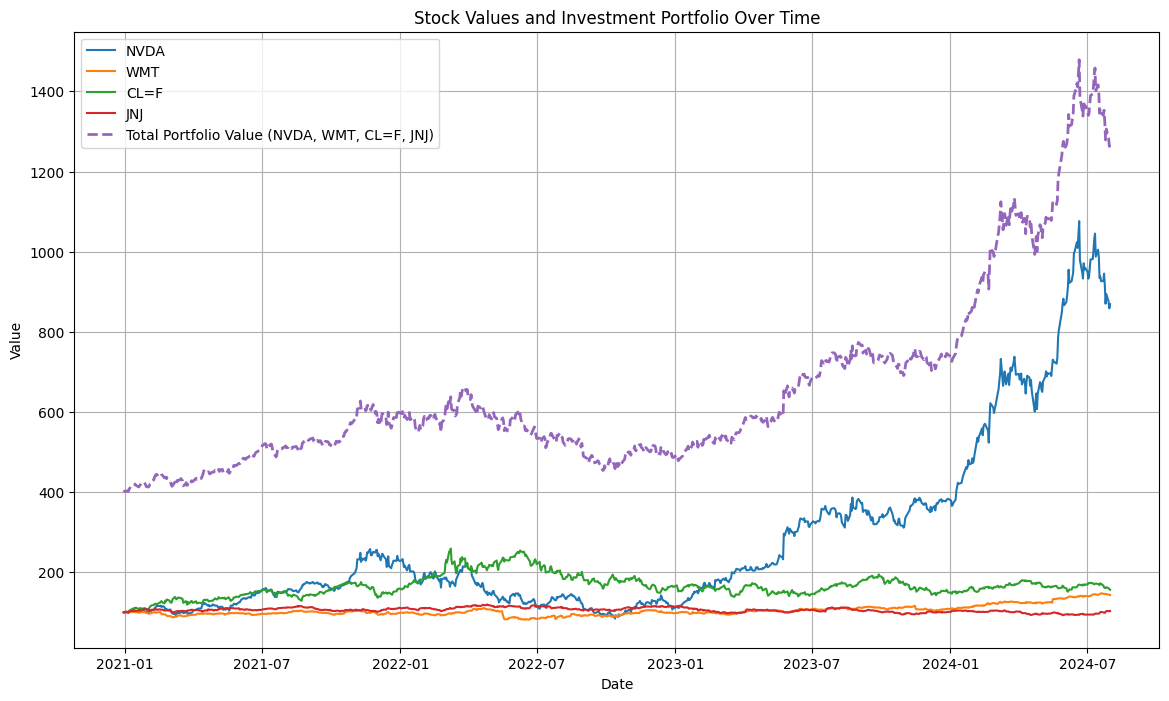

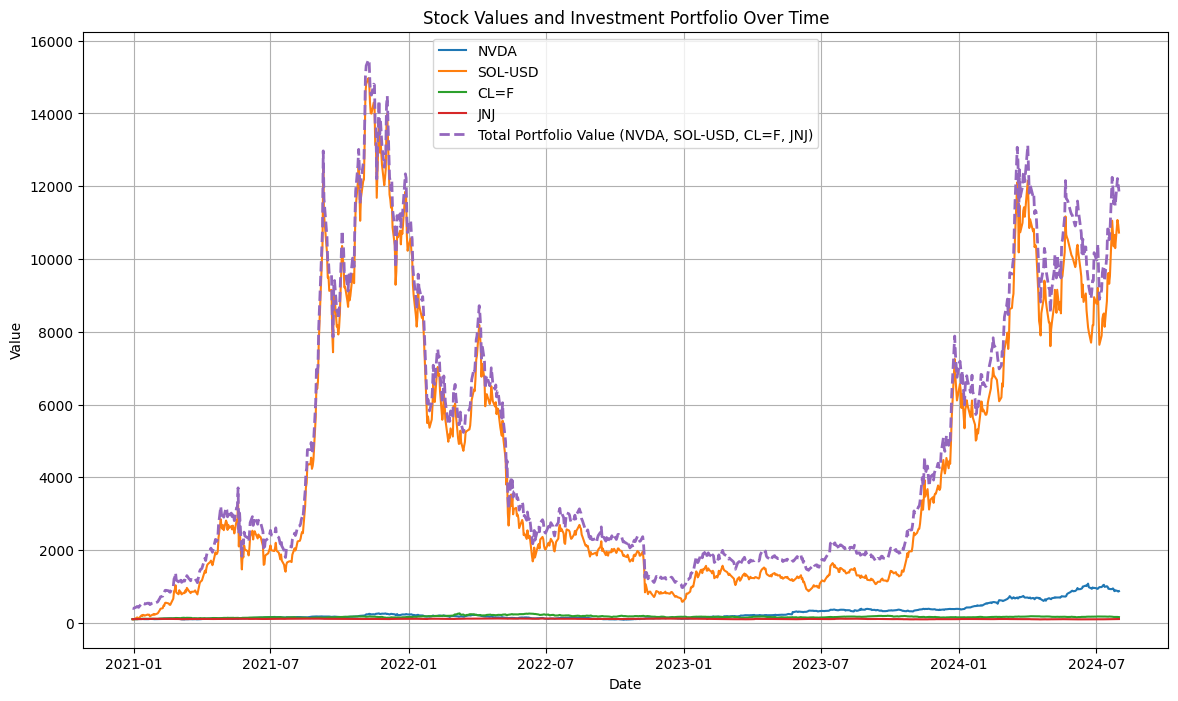

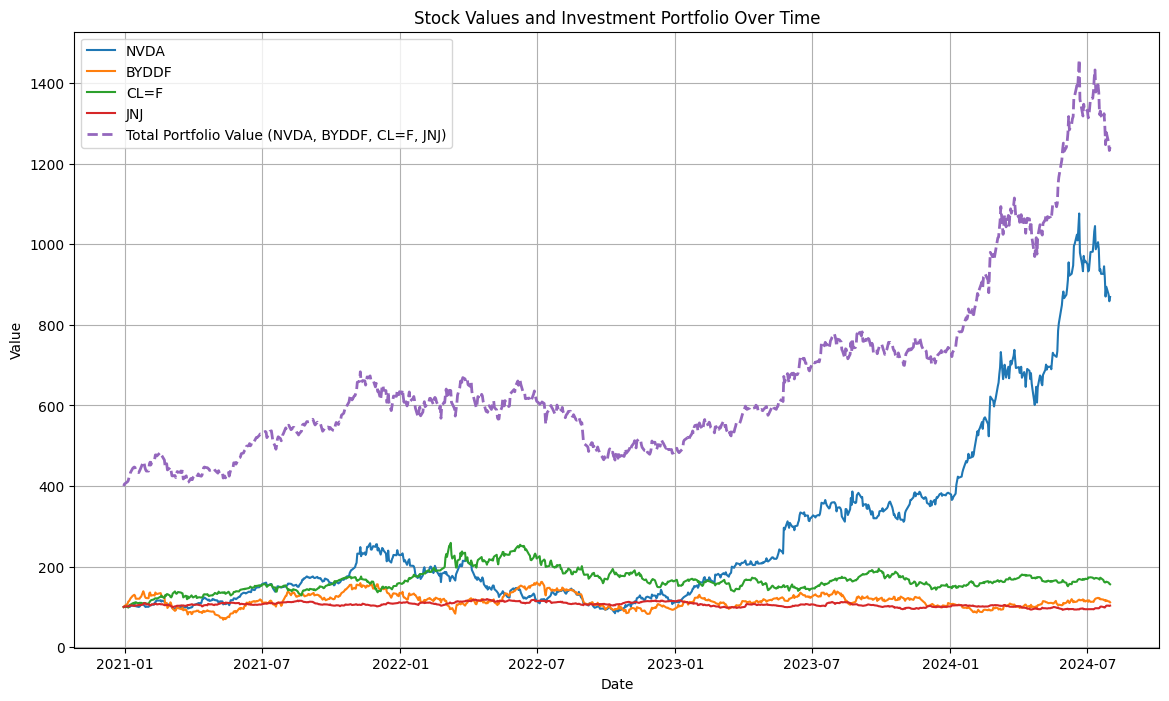

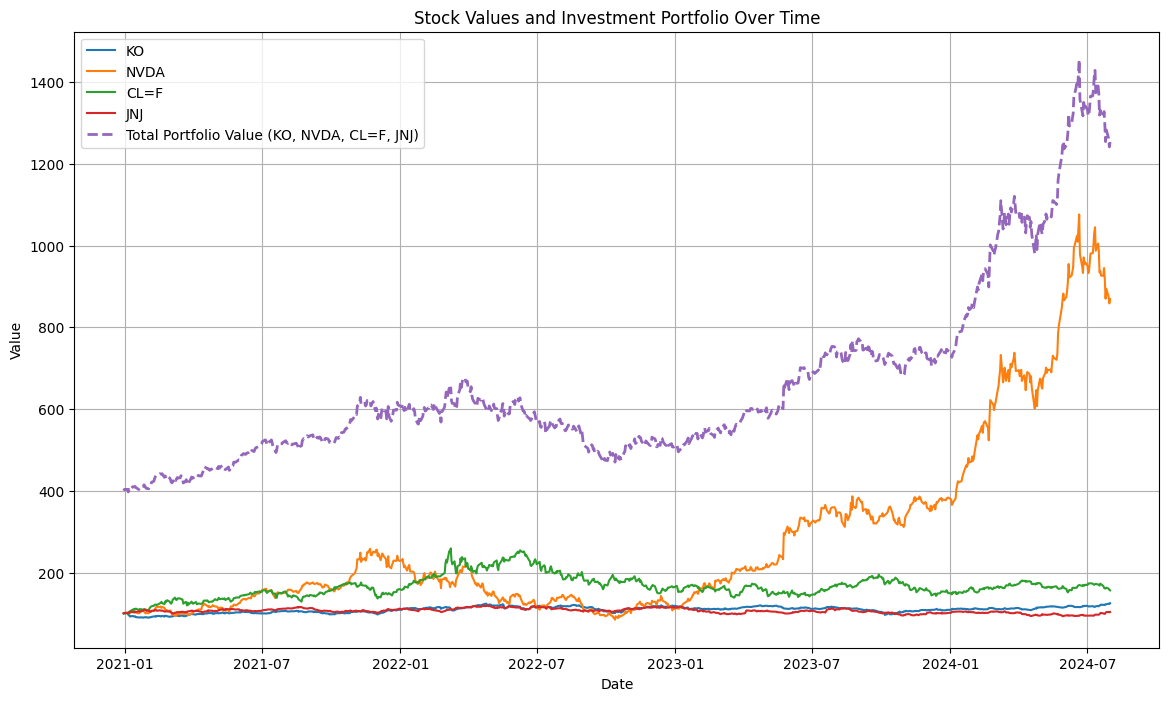

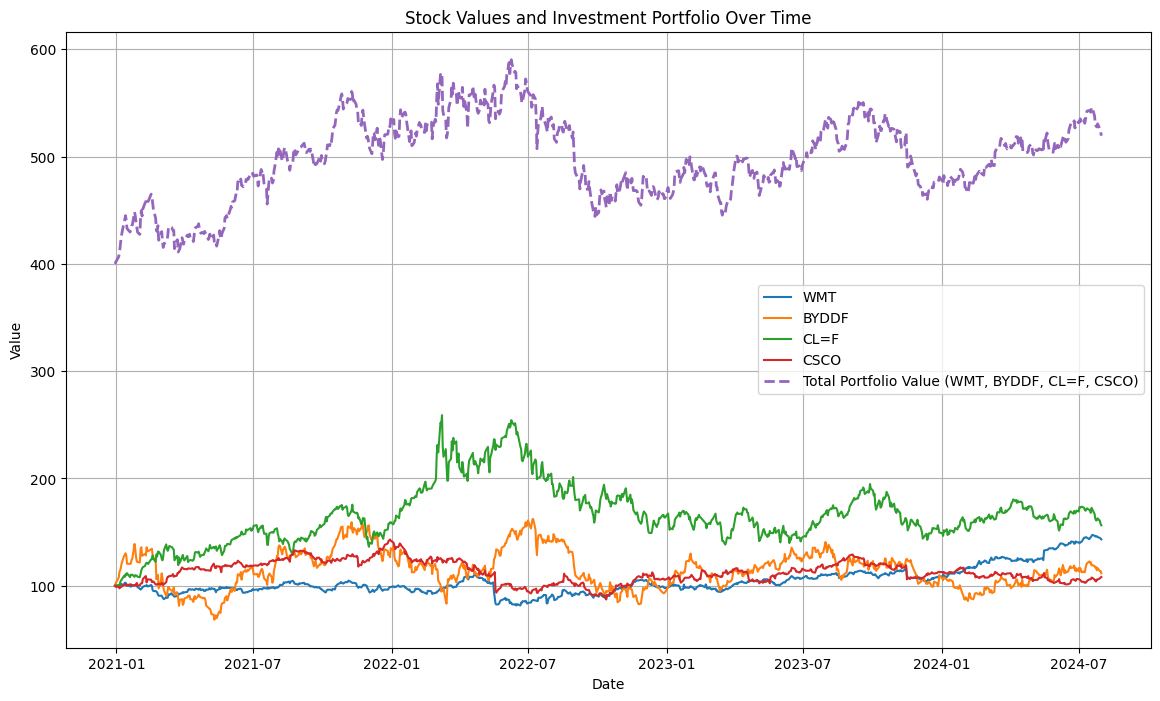

In [61]:
visualize_portfolio(cleaned_data, purchase_date, best_combinations_monthly, investment_amount)